# Resizing and padding

In [289]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [290]:
import os
from os.path import join


import numpy as np
import pandas as pd
import cv2
import pickle
from tqdm import tqdm
from PIL import Image
from random import randint
import matplotlib.pyplot as plt

import tensorflow as tf



from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from tensorflow.keras.models import  load_model,Model
from tensorflow.keras import applications
from tensorflow.keras.layers import Lambda,Input,Dropout, Activation, Dense, GlobalMaxPooling2D,Conv2D,Flatten,MaxPooling2D,InputLayer
from tensorflow.keras.utils import to_categorical

from efficientnet.tfkeras import EfficientNetB7
from tensorflow.keras import datasets
from foolbox.attacks import LinfFastGradientAttack,LinfDeepFoolAttack
from foolbox.distances import LpDistance
from foolbox.models import TensorFlowModel
from foolbox import criteria
from sklearn.metrics import classification_report,plot_roc_curve

from art.attacks.evasion import SaliencyMapMethod
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import BoundaryAttack
from art.utils import load_dataset #to play with cifar images
from tensorflow.keras.layers.experimental import preprocessing
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4*1024)]
)

#### 1. Load Data

In [291]:
data=datasets.mnist.load_data(path='mnist.npz')
X_train,y_train=data[0][0],data[0][1]
X_test,y_test=data[1][0],data[1][1]
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [292]:
""" Train """
X_train_img = np.full((60000, 32, 32, 3), 0)
for i, s in enumerate(X_train):
    X_train_img[i] = cv2.cvtColor(np.pad(s,2), cv2.COLOR_GRAY2RGB)
    
""" Test """
X_test_img = np.full((10000, 32, 32, 3), 0)
for i, s in enumerate(X_test):
    X_test_img[i] = cv2.cvtColor(np.pad(s,2), cv2.COLOR_GRAY2RGB)
    
X_train=X_train_img
X_test= X_test_img

#### 2. Load models

Nous allons comparer les attaques sur efficientNet,VGG   


Afin de tester certaines attaques plus longues (comme JSMA) nous créons également un petit modèle 

In [342]:
def resize_and_pad(image):
        new_size=randint(15,32)
        left_offset=randint(0,32-new_size)
        top_offset=randint(0,32-new_size)
        image=tf.cast(image,dtype='float32')/255
        paddings = tf.constant([[0,0],[top_offset,32-top_offset-new_size],[left_offset,32-left_offset-new_size],[0,0]])
        image=tf.image.resize(image, [new_size,new_size], method='nearest', preserve_aspect_ratio=True)
        image=tf.pad(image, paddings, mode='CONSTANT', constant_values=0, name=None)
        return(image)
    
def resize_pad_layer(factor=0.5):
    return Lambda(lambda x: resize_and_pad(x))


resize_pad_layer = resize_pad_layer()


class ResizePad(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ResizePad,self).__init__(**kwargs)       

    def call(self, x):
        return resize_pad_layer(x)

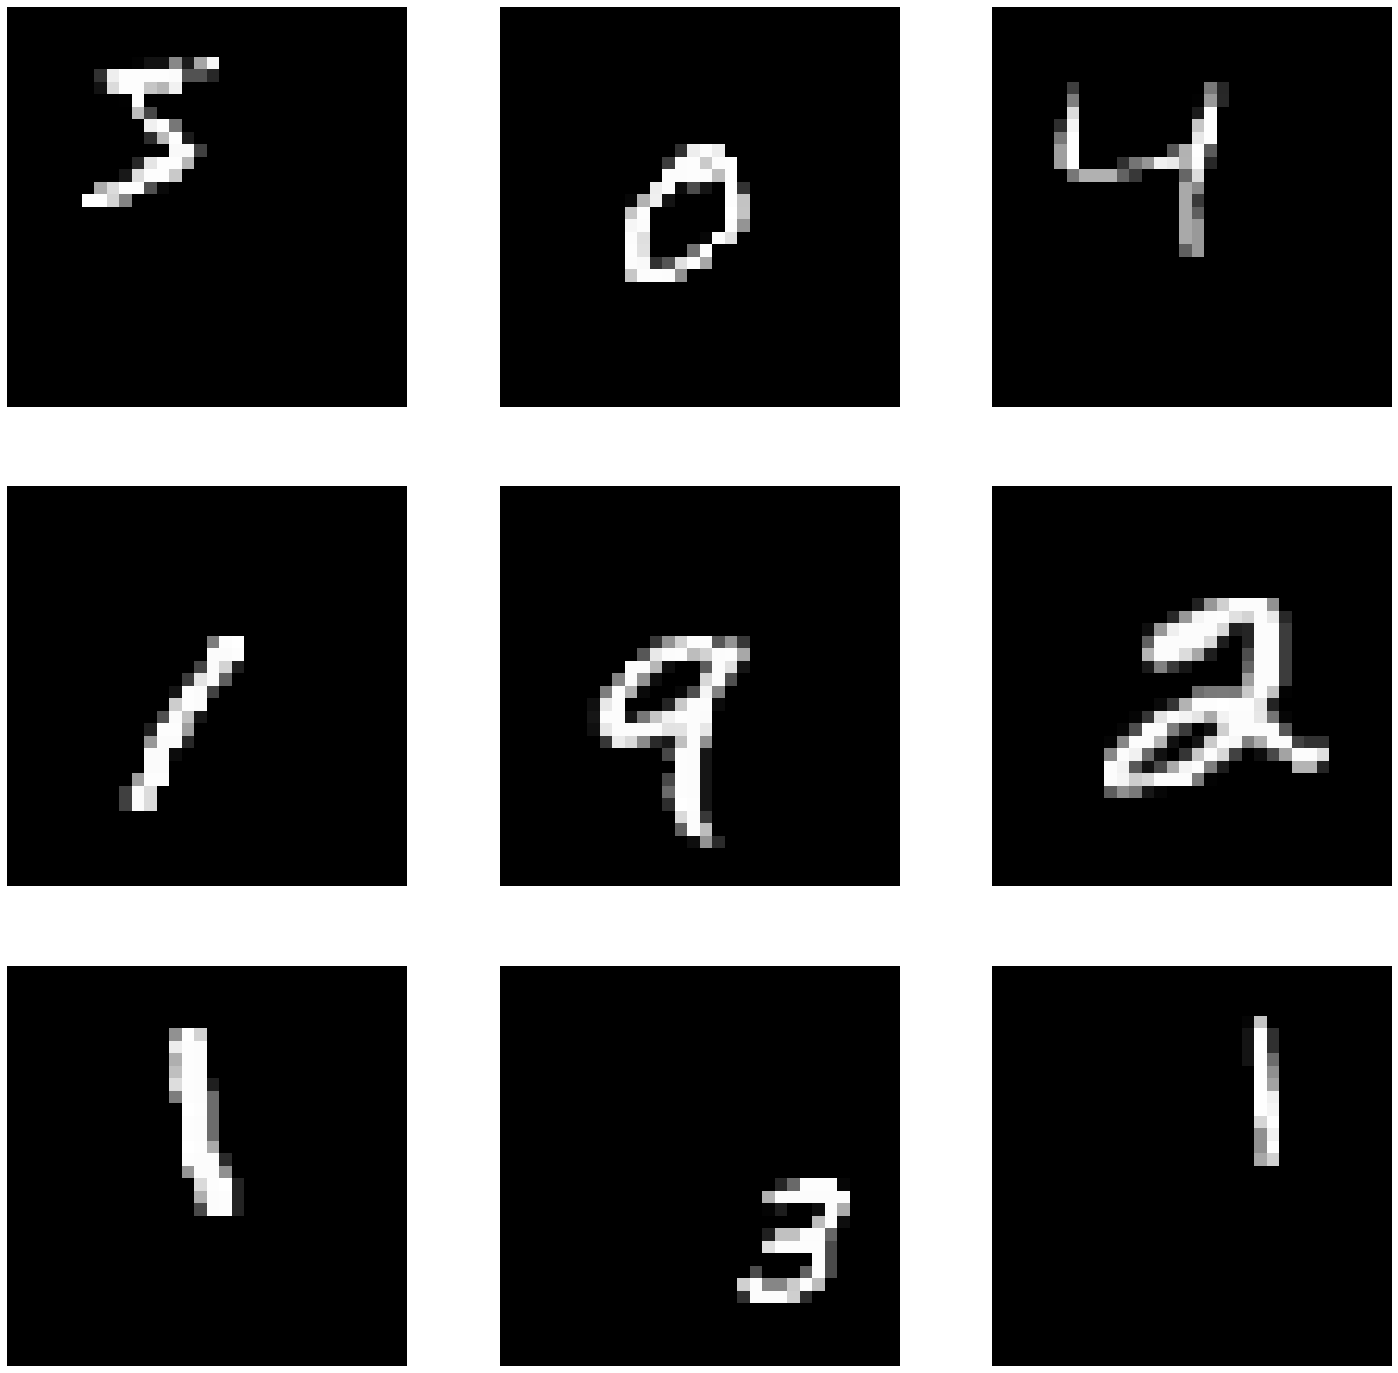

In [344]:
plt.figure(figsize=(25,25))
for i,image in enumerate(X_train[:9]): 
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(ResizePad()(np.expand_dims(X_train[i],axis=0))[0])
    plt.axis("off")

In [295]:
small_model_with_def = tf.keras.models.Sequential()
small_model_with_def.add(ResizePad())
small_model_with_def.add(Conv2D(64, (3, 3), activation='relu'))
small_model_with_def.add(MaxPooling2D(2, 2))
small_model_with_def.add(Conv2D(64, (3, 3), activation='relu'))
small_model_with_def.add(MaxPooling2D(2, 2))
small_model_with_def.add(Conv2D(64, (3, 3), activation='relu'))
small_model_with_def.add(MaxPooling2D(2, 2))
small_model_with_def.add(Flatten())
small_model_with_def.add(Dense(256, activation='relu'))
small_model_with_def.add(Dropout(0.3))
small_model_with_def.add(Dense(128, activation='relu'))
small_model_with_def.add(Dense(10, activation='softmax'))


tf.keras.optimizers.Adam(
    learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')


small_model_with_def.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
    )


history = small_model_with_def.fit(X_train, y_train,
              epochs=10,
              batch_size = 128,
              validation_split=0.1,
              shuffle=True,
              verbose=1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 4s 77us/sample - loss: 0.2868 - accuracy: 0.9073 - val_loss: 3.5823 - val_accuracy: 0.2150
Epoch 2/10
54000/54000 [==============================] - 4s 68us/sample - loss: 0.0742 - accuracy: 0.9771 - val_loss: 3.9060 - val_accuracy: 0.2107
Epoch 3/10
54000/54000 [==============================] - 4s 68us/sample - loss: 0.0530 - accuracy: 0.9830 - val_loss: 3.4853 - val_accuracy: 0.2200
Epoch 4/10
54000/54000 [==============================] - 4s 68us/sample - loss: 0.0405 - accuracy: 0.9873 - val_loss: 3.8941 - val_accuracy: 0.2312
Epoch 5/10
54000/54000 [==============================] - 4s 68us/sample - loss: 0.0359 - accuracy: 0.9886 - val_loss: 3.9470 - val_accuracy: 0.2067
Epoch 6/10
54000/54000 [==============================] - 4s 68us/sample - loss: 0.0281 - accuracy: 0.9909 - val_loss: 3.9837 - val_accuracy: 0.2235
Epoch 7/10
54000/54000 [==============================] -

In [332]:
y_pred_small_model_with_def=[np.argmax(pred) for pred in small_model_with_def.predict(X_test)]
y_true=[np.argmax(y) for y in y_test]
classification_small_model_with_def=classification_report(y_true, y_pred_small_model_with_def)
print(classification_small_model_with_def)

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       980
           1       1.00      0.97      0.98      1135
           2       0.96      0.95      0.95      1032
           3       0.94      0.98      0.96      1010
           4       0.99      0.93      0.96       982
           5       0.85      0.98      0.91       892
           6       0.96      0.94      0.95       958
           7       0.95      0.93      0.94      1028
           8       0.90      0.92      0.91       974
           9       0.90      0.92      0.91      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [346]:
small_model = tf.keras.models.Sequential()
small_model.add(Conv2D(64, (3, 3), activation='relu',input_shape=(32,32,3)))
small_model.add(MaxPooling2D(2, 2))
small_model.add(Conv2D(64, (3, 3), activation='relu'))
small_model.add(MaxPooling2D(2, 2))
small_model.add(Conv2D(64, (3, 3), activation='relu'))
small_model.add(MaxPooling2D(2, 2))
small_model.add(Flatten())
small_model.add(Dense(256, activation='relu'))
small_model.add(Dropout(0.3))
small_model.add(Dense(128, activation='relu'))
small_model.add(Dense(10, activation='softmax'))


tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')


small_model.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
    )


history = small_model.fit(X_train, y_train,
              epochs=5,
              batch_size = 128,
              validation_split=0.1,
              shuffle=True,
              verbose=1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 4s 76us/sample - loss: 0.5925 - accuracy: 0.8795 - val_loss: 0.0811 - val_accuracy: 0.9763
Epoch 2/20
54000/54000 [==============================] - 4s 67us/sample - loss: 0.0960 - accuracy: 0.9704 - val_loss: 0.0601 - val_accuracy: 0.9823
Epoch 3/20
54000/54000 [==============================] - 4s 67us/sample - loss: 0.0669 - accuracy: 0.9795 - val_loss: 0.0424 - val_accuracy: 0.9877
Epoch 4/20
54000/54000 [==============================] - 4s 67us/sample - loss: 0.0570 - accuracy: 0.9825 - val_loss: 0.0379 - val_accuracy: 0.9888
Epoch 5/20
54000/54000 [==============================] - 4s 67us/sample - loss: 0.0491 - accuracy: 0.9847 - val_loss: 0.0383 - val_accuracy: 0.9903
Epoch 6/20
54000/54000 [==============================] - 4s 68us/sample - loss: 0.0408 - accuracy: 0.9875 - val_loss: 0.0356 - val_accuracy: 0.9908
Epoch 7/20
54000/54000 [==============================] -

In [340]:
inputs=Input(shape=(32,32,3))
x=ResizePad()(inputs)
outputs=small_model(x)
new_model=Model(inputs,[outputs])

In [345]:
y_pred_small_model=[np.argmax(pred) for pred in new_model.predict(X_test)]
y_true=[np.argmax(y) for y in y_test]
classification_small_model=classification_report(y_true, y_pred_small_model)
print(classification_small_model)

              precision    recall  f1-score   support

           0       1.00      0.02      0.03       980
           1       0.80      1.00      0.89      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.11      1.00      0.20       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.21     10000
   macro avg       0.19      0.20      0.11     10000
weighted avg       0.20      0.21      0.12     10000



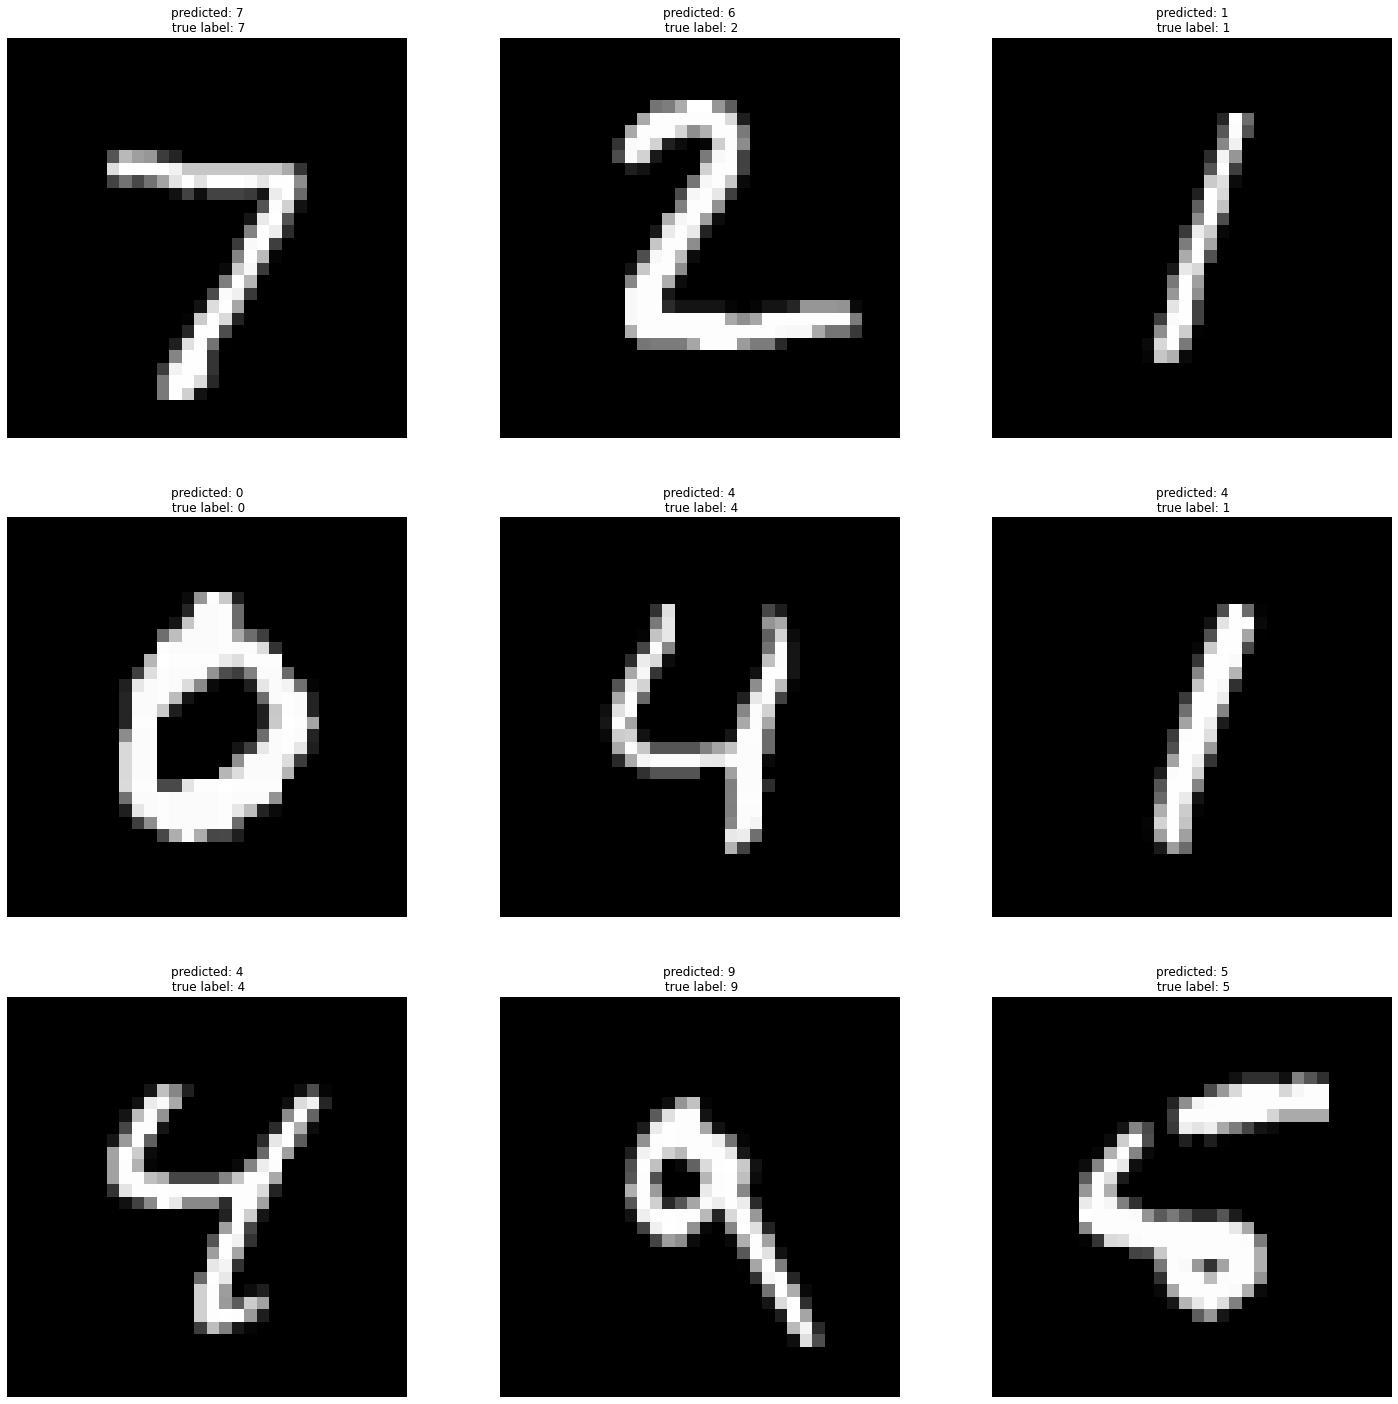

In [304]:
plt.figure(figsize=(25,25))
for i,(image,label) in enumerate(zip(X_test[:9],y_test[:9])): 
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    true_label=np.argmax(label)
    predicted_label=np.argmax(small_model_with_def(np.expand_dims(image,axis=0)))
    plt.title("predicted: "+str(predicted_label)+"\n true label: "+str(true_label))
    plt.axis("off")

#### 4. Load attacks 

contrast_enhancer permet d augmenter le bruit lorsqu il est très faible

In [212]:
def contrast_enhancer(image_noise):    
    for i in range (3):
        color_axis=image_noise[:,:,i]
        color_axis =((color_axis -np.min(color_axis))/np.ptp(color_axis))
        image_noise[:,:,i]=color_axis
    image_noise=image_noise #in order to have the darker colors corresponding to the biggest changes
    return(image_noise)

Let's define the peformances metrics

In [213]:
def DOC (x_adv_list,x_list): #degree of change
    N=len(x_adv_list)
    sum=0
    for i in range (N):        
        sum+=100*np.linalg.norm(np.reshape(x_adv_list[i] - x_list[i], -1),ord=1)/np.linalg.norm(np.reshape(x_list[i], -1),ord=1)
    return(sum/N)

def succes_rate (success_list):
    success=len([i for i in success_list if i==True])
    total=len(success_list)
    return(success/total)

In [145]:
model_to_fool = TensorFlowModel(model_effnet, bounds=(0, 255))


attack_deepfool_1_steps=LinfDeepFoolAttack(steps=1)
attack_deepfool_mutliple_steps=LinfDeepFoolAttack()
attack_FGSM=LinfFastGradientAttack()


###  Defense implementation


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 156.76it/s]

Adversarial image at step 0. L2 error 7929.517228212172 and class label 6.


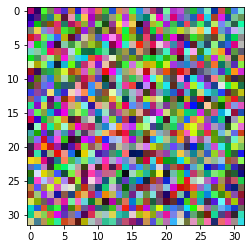

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]


Adversarial image at step 1. L2 error 7921.563926206382 and class label 6.


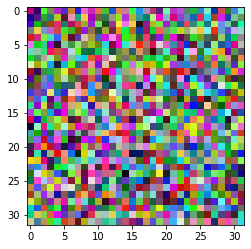

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]


Adversarial image at step 2. L2 error 7909.810424748681 and class label 6.


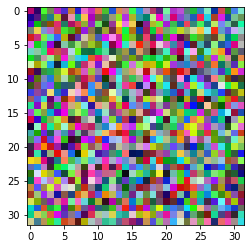

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]


Adversarial image at step 3. L2 error 7892.355494808378 and class label 6.


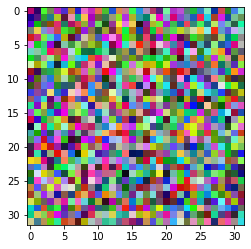

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]


Adversarial image at step 4. L2 error 7865.952174312452 and class label 6.


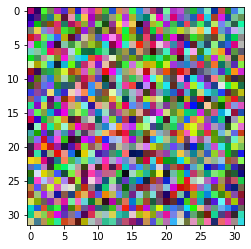

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]


Adversarial image at step 5. L2 error 7825.575998973524 and class label 6.


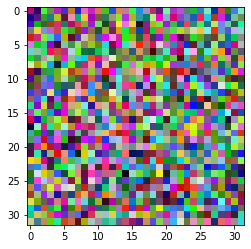

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]


Adversarial image at step 6. L2 error 7767.15133038691 and class label 6.


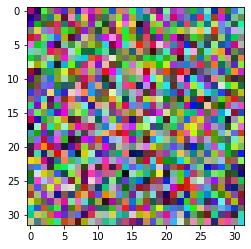

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]


Adversarial image at step 7. L2 error 7678.672950022259 and class label 6.


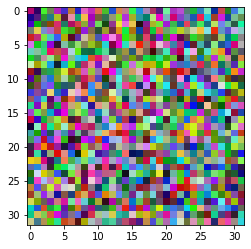

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]


Adversarial image at step 8. L2 error 7549.343202429906 and class label 6.


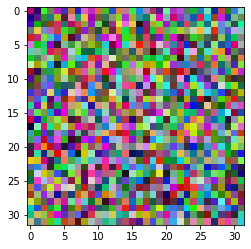

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]


Adversarial image at step 9. L2 error 7353.272070392908 and class label 6.


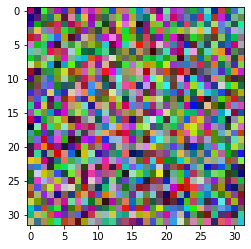

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


Adversarial image at step 10. L2 error 7073.74369461121 and class label 6.


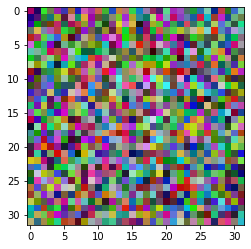

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


Adversarial image at step 11. L2 error 6673.797610530085 and class label 6.


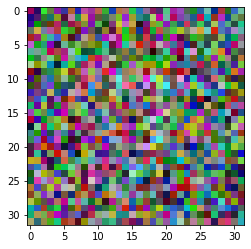

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


Adversarial image at step 12. L2 error 6101.405288207604 and class label 6.


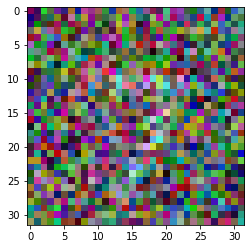

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]


Adversarial image at step 13. L2 error 5576.419580391859 and class label 6.


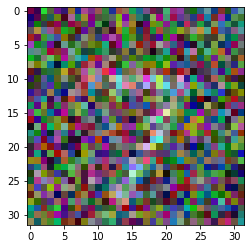

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


Adversarial image at step 14. L2 error 5094.607251631319 and class label 6.


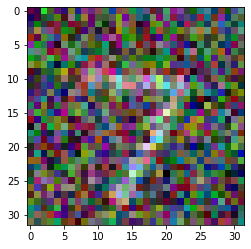

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


Adversarial image at step 15. L2 error 4446.454593728963 and class label 6.


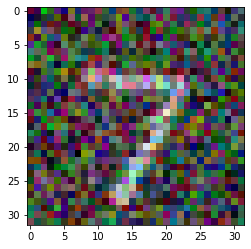

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


Adversarial image at step 16. L2 error 4163.143682987162 and class label 6.


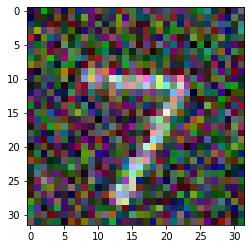

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


Adversarial image at step 17. L2 error 3909.7409496457717 and class label 6.


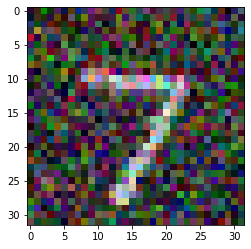

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


Adversarial image at step 18. L2 error 3748.5012745438667 and class label 6.


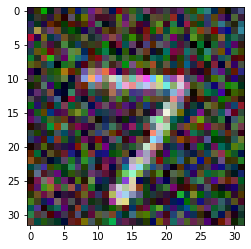

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


Adversarial image at step 19. L2 error 3531.8111063109727 and class label 6.


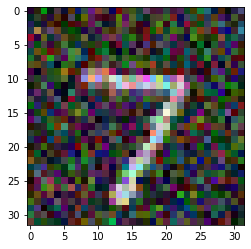

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.76it/s]


Adversarial image at step 20. L2 error 3391.17257592637 and class label 6.


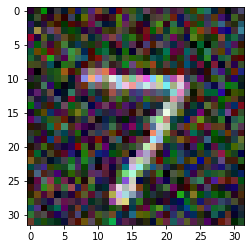

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


Adversarial image at step 21. L2 error 3339.5190069547953 and class label 6.


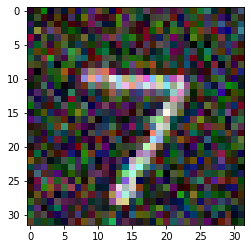

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Adversarial image at step 22. L2 error 3255.493076354936 and class label 6.


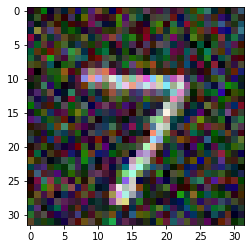

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.67it/s]


Adversarial image at step 23. L2 error 3249.5464114499655 and class label 6.


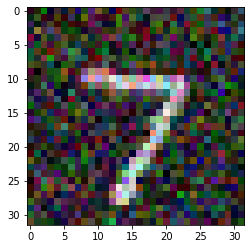

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


Adversarial image at step 24. L2 error 3235.319971277104 and class label 6.


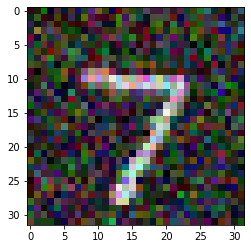

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


Adversarial image at step 25. L2 error 3209.0823531876554 and class label 6.


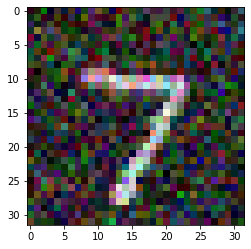

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


Adversarial image at step 26. L2 error 3172.2797350128358 and class label 6.


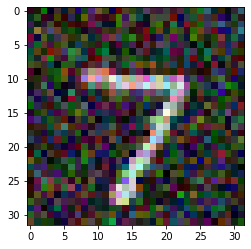

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]


Adversarial image at step 27. L2 error 3137.707788138205 and class label 6.


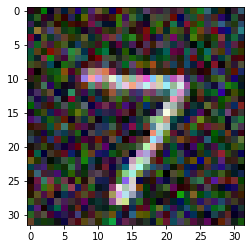

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]


Adversarial image at step 28. L2 error 3085.4102549720783 and class label 6.


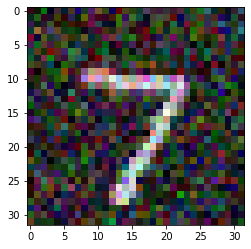

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


Adversarial image at step 29. L2 error 3007.3739690839952 and class label 6.


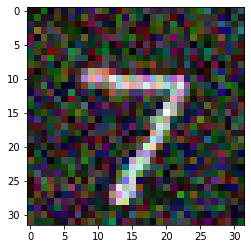

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


Adversarial image at step 30. L2 error 2921.85024098605 and class label 6.


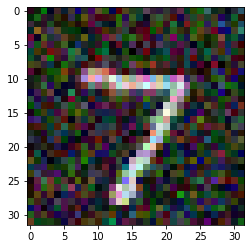

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


Adversarial image at step 31. L2 error 2843.060349018411 and class label 6.


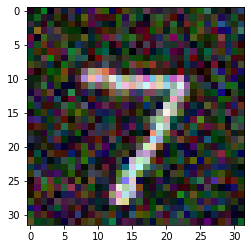

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


Adversarial image at step 32. L2 error 2838.2317855125502 and class label 6.


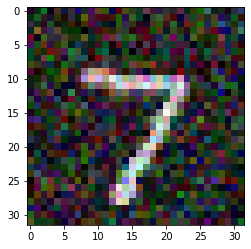

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


Adversarial image at step 33. L2 error 2834.172914215642 and class label 6.


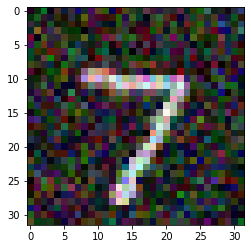

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


Adversarial image at step 34. L2 error 2825.2523601678004 and class label 6.


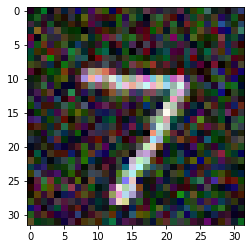

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


Adversarial image at step 35. L2 error 2815.6437602681367 and class label 6.


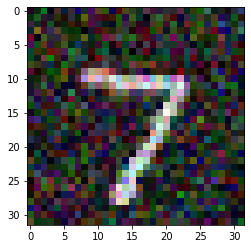

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


Adversarial image at step 36. L2 error 2801.085557380074 and class label 6.


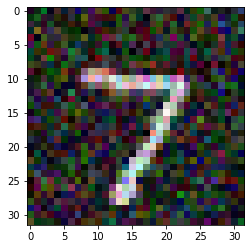

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


Adversarial image at step 37. L2 error 2788.151934094869 and class label 6.


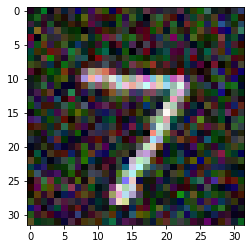

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


Adversarial image at step 38. L2 error 2774.8616687913395 and class label 6.


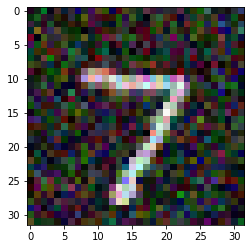

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]


Adversarial image at step 39. L2 error 2760.7834591183655 and class label 6.


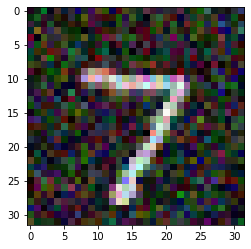

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


Adversarial image at step 40. L2 error 2746.867169662728 and class label 6.


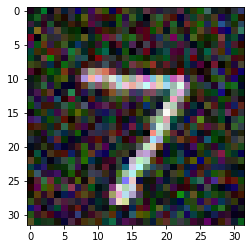

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]


Adversarial image at step 41. L2 error 2739.8154995368727 and class label 6.


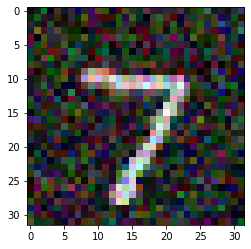

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


Adversarial image at step 42. L2 error 2732.064141039214 and class label 6.


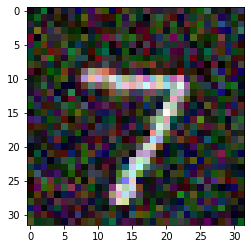

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


Adversarial image at step 43. L2 error 2726.345545429121 and class label 6.


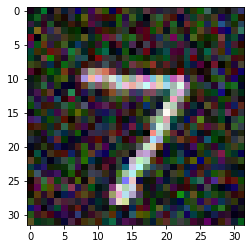

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


Adversarial image at step 44. L2 error 2717.9043186070044 and class label 6.


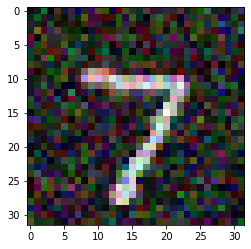

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]


Adversarial image at step 45. L2 error 2708.0824472379545 and class label 6.


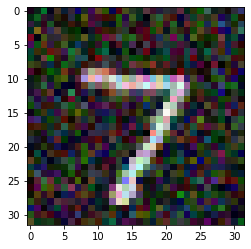

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Adversarial image at step 46. L2 error 2700.439384631614 and class label 6.


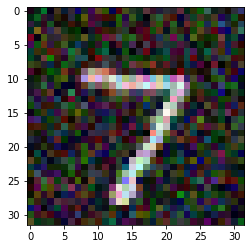

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]


Adversarial image at step 47. L2 error 2694.210429349156 and class label 6.


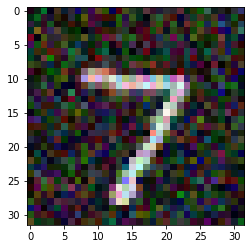

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


Adversarial image at step 48. L2 error 2686.0573649007333 and class label 6.


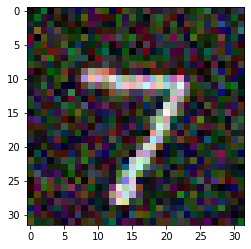

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


Adversarial image at step 49. L2 error 2671.8065640223595 and class label 6.


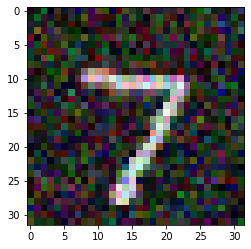

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]


Adversarial image at step 50. L2 error 2662.2455879020604 and class label 6.


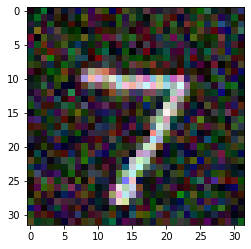

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


Adversarial image at step 51. L2 error 2647.99323214859 and class label 6.


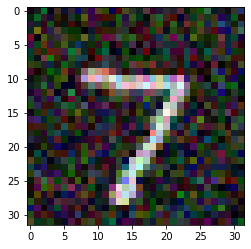

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


Adversarial image at step 52. L2 error 2634.168325584905 and class label 6.


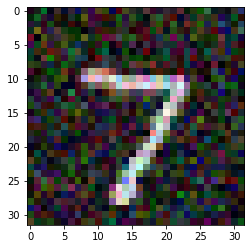

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


Adversarial image at step 53. L2 error 2622.4465494221645 and class label 6.


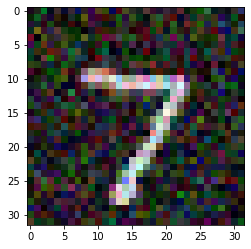

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.63it/s]


Adversarial image at step 54. L2 error 2604.214991756177 and class label 6.


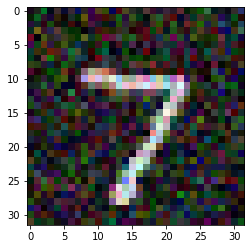

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


Adversarial image at step 55. L2 error 2574.2474589980875 and class label 6.


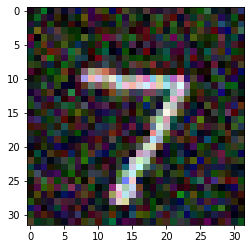

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


Adversarial image at step 56. L2 error 2568.588846338123 and class label 6.


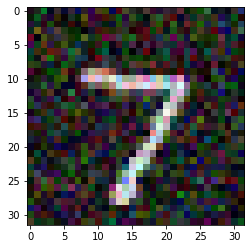

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.04it/s]


Adversarial image at step 57. L2 error 2561.06248908147 and class label 6.


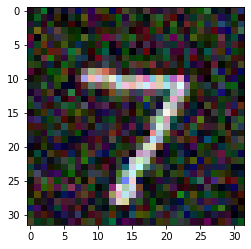

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.61it/s]


Adversarial image at step 58. L2 error 2547.050514002259 and class label 6.


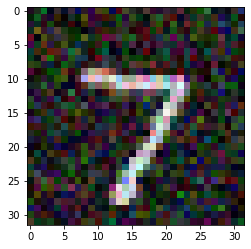

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


Adversarial image at step 59. L2 error 2529.556805683259 and class label 6.


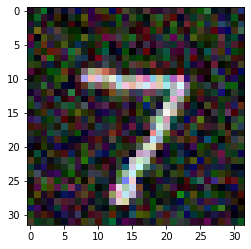

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


Adversarial image at step 60. L2 error 2516.2706354949246 and class label 6.


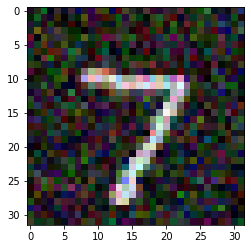

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.62it/s]


Adversarial image at step 61. L2 error 2504.2749269028845 and class label 6.


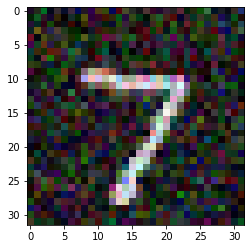

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


Adversarial image at step 62. L2 error 2494.5808420537464 and class label 6.


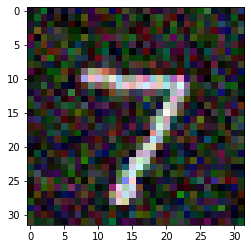

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


Adversarial image at step 63. L2 error 2481.0142402438087 and class label 6.


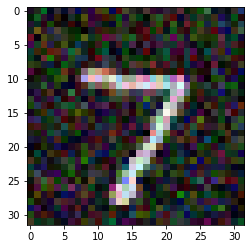

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.62it/s]


Adversarial image at step 64. L2 error 2462.250207666903 and class label 6.


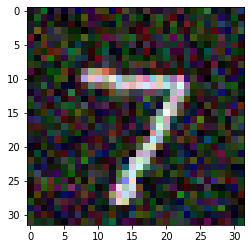

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


Adversarial image at step 65. L2 error 2439.077460665763 and class label 6.


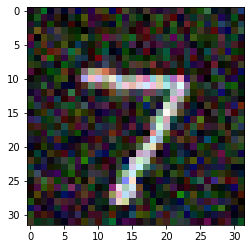

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


Adversarial image at step 66. L2 error 2420.9082340734863 and class label 6.


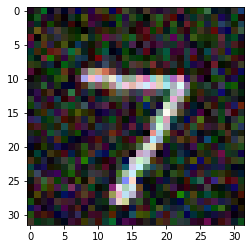

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


Adversarial image at step 67. L2 error 2403.6301090671695 and class label 6.


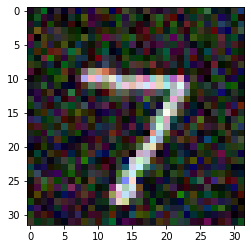

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


Adversarial image at step 68. L2 error 2384.2914911677417 and class label 6.


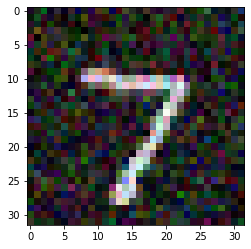

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.63it/s]


Adversarial image at step 69. L2 error 2364.95117183149 and class label 6.


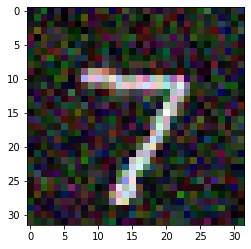

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


Adversarial image at step 70. L2 error 2340.4081065096966 and class label 6.


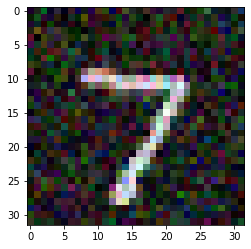

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.60it/s]


Adversarial image at step 71. L2 error 2326.0122746967713 and class label 6.


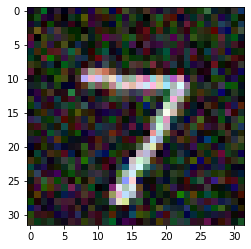

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


Adversarial image at step 72. L2 error 2314.3101006181864 and class label 6.


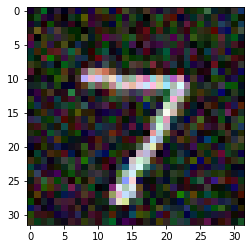

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


Adversarial image at step 73. L2 error 2296.9502553972966 and class label 6.


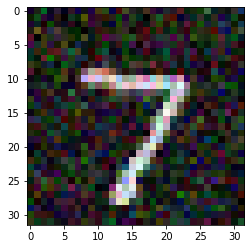

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]


Adversarial image at step 74. L2 error 2277.275419195346 and class label 6.


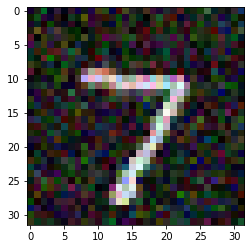

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


Adversarial image at step 75. L2 error 2259.7834101624953 and class label 6.


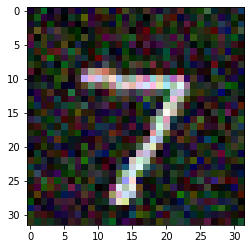

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


Adversarial image at step 76. L2 error 2235.223698425067 and class label 6.


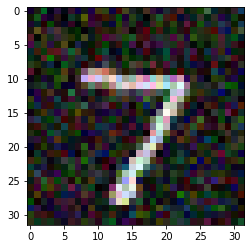

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


Adversarial image at step 77. L2 error 2208.399387673654 and class label 6.


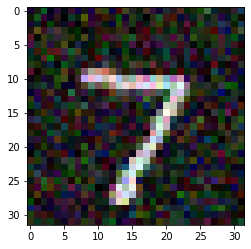

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]


Adversarial image at step 78. L2 error 2204.647430755163 and class label 6.


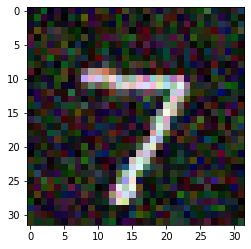

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


Adversarial image at step 79. L2 error 2202.215218081845 and class label 6.


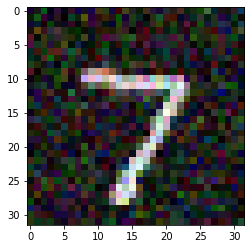

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


Adversarial image at step 80. L2 error 2197.5484584000164 and class label 6.


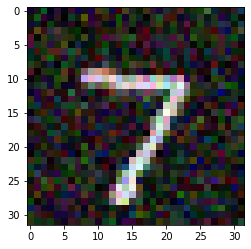

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


Adversarial image at step 81. L2 error 2187.2197680629347 and class label 6.


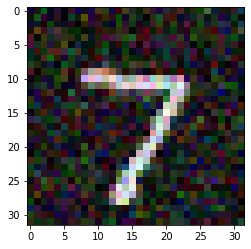

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


Adversarial image at step 82. L2 error 2171.1355614789722 and class label 6.


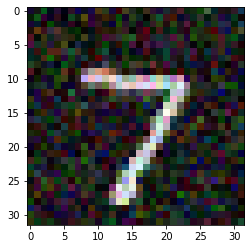

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


Adversarial image at step 83. L2 error 2168.8740720075352 and class label 6.


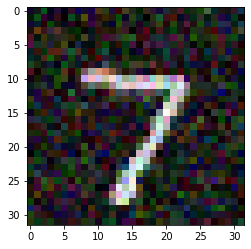

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


Adversarial image at step 84. L2 error 2167.2531547221374 and class label 6.


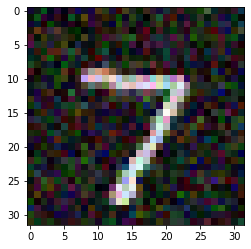

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


Adversarial image at step 85. L2 error 2169.5498463038266 and class label 6.


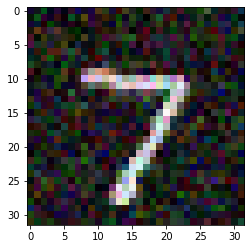

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


Adversarial image at step 86. L2 error 2165.110266090585 and class label 6.


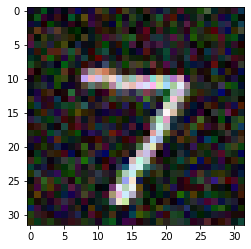

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


Adversarial image at step 87. L2 error 2160.3737186437156 and class label 6.


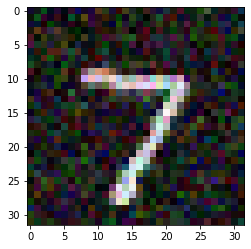

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


Adversarial image at step 88. L2 error 2154.322365617147 and class label 6.


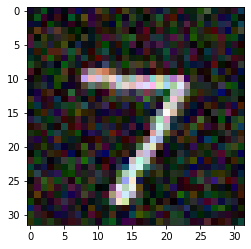

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


Adversarial image at step 89. L2 error 2148.182837051369 and class label 6.


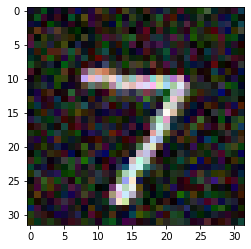

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


Adversarial image at step 90. L2 error 2137.3839409901148 and class label 6.


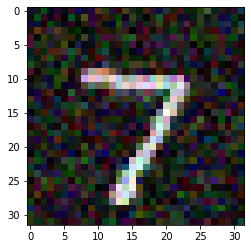

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


Adversarial image at step 91. L2 error 2125.596561170072 and class label 6.


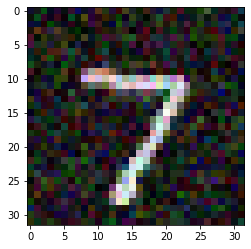

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


Adversarial image at step 92. L2 error 2107.912430875859 and class label 6.


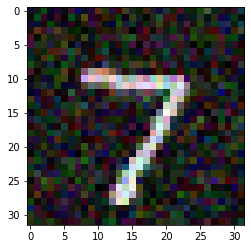

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


Adversarial image at step 93. L2 error 2092.6758384235154 and class label 6.


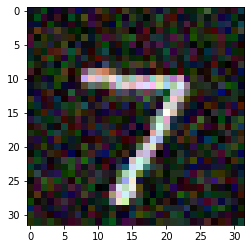

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


Adversarial image at step 94. L2 error 2075.2643564185028 and class label 6.


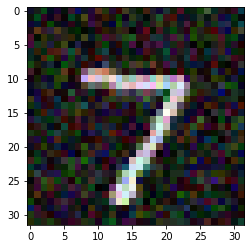

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


Adversarial image at step 95. L2 error 2057.1902303778893 and class label 6.


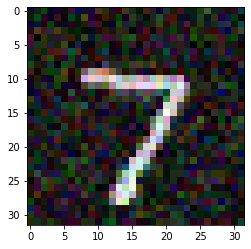

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


Adversarial image at step 96. L2 error 2031.8062335133318 and class label 6.


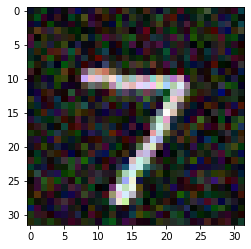

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


Adversarial image at step 97. L2 error 2007.581109025147 and class label 6.


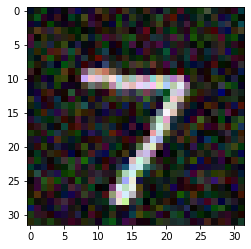

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


Adversarial image at step 98. L2 error 1981.047888693731 and class label 6.


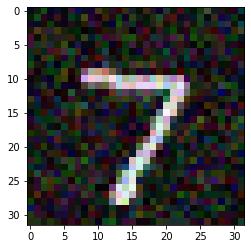

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


Adversarial image at step 99. L2 error 1947.576085400031 and class label 6.


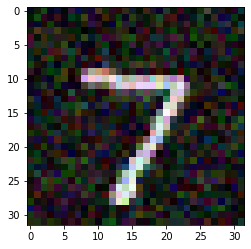

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


Adversarial image at step 100. L2 error 1912.8454986489226 and class label 6.


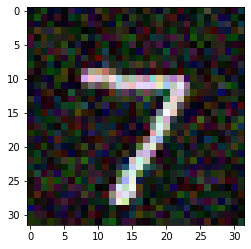

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


Adversarial image at step 101. L2 error 1893.4847427857721 and class label 6.


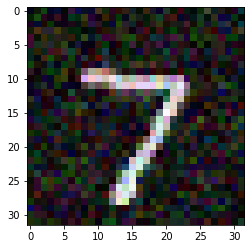

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


Adversarial image at step 102. L2 error 1871.4414915196667 and class label 6.


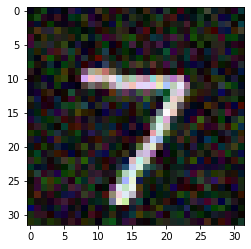

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


Adversarial image at step 103. L2 error 1863.1586680454113 and class label 6.


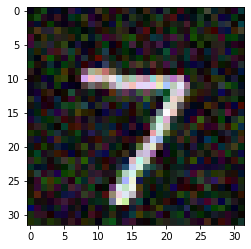

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


Adversarial image at step 104. L2 error 1857.6003385927147 and class label 6.


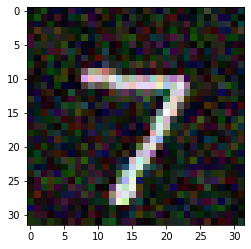

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]


Adversarial image at step 105. L2 error 1851.790981083076 and class label 6.


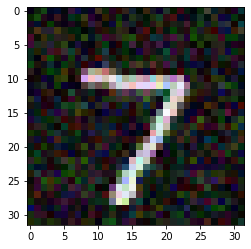

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


Adversarial image at step 106. L2 error 1847.192819677227 and class label 6.


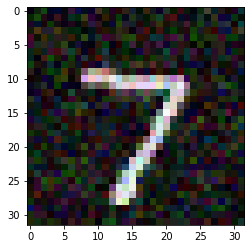

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Adversarial image at step 107. L2 error 1836.554914351028 and class label 6.


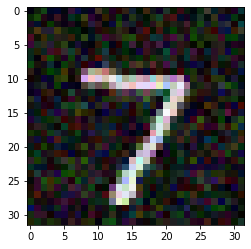

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]


Adversarial image at step 108. L2 error 1829.2546279042126 and class label 6.


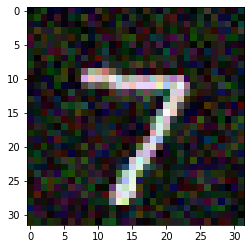

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


Adversarial image at step 109. L2 error 1822.6211362211498 and class label 6.


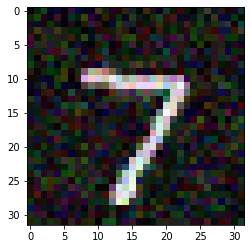

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


Adversarial image at step 110. L2 error 1816.8823367793177 and class label 6.


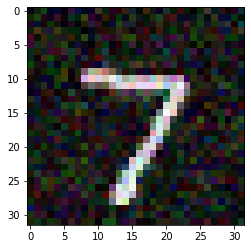

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


Adversarial image at step 111. L2 error 1812.3759192592927 and class label 6.


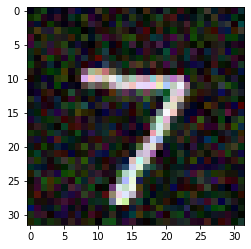

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]


Adversarial image at step 112. L2 error 1809.0494280976754 and class label 6.


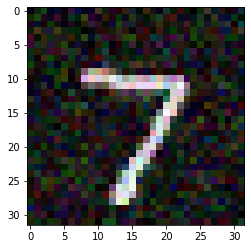

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.77it/s]


Adversarial image at step 113. L2 error 1802.5106367927242 and class label 6.


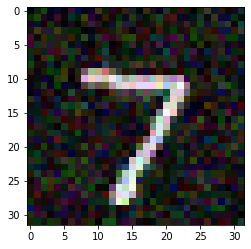

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


Adversarial image at step 114. L2 error 1795.9738801518881 and class label 6.


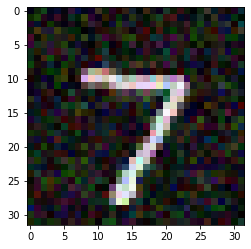

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


Adversarial image at step 115. L2 error 1791.903361416014 and class label 6.


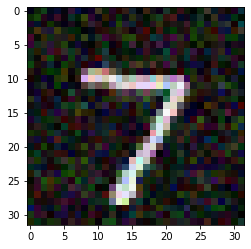

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


Adversarial image at step 116. L2 error 1784.7157867377498 and class label 6.


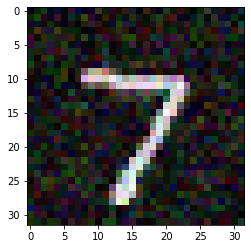

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


Adversarial image at step 117. L2 error 1775.808924334574 and class label 6.


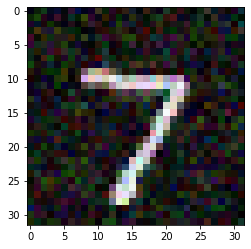

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


Adversarial image at step 118. L2 error 1766.4456012446005 and class label 6.


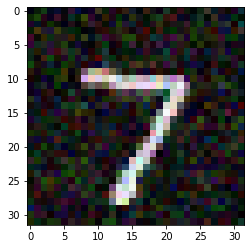

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


Adversarial image at step 119. L2 error 1763.135602593836 and class label 6.


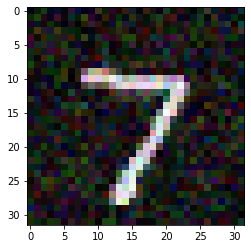

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


Adversarial image at step 120. L2 error 1759.2592775619814 and class label 6.


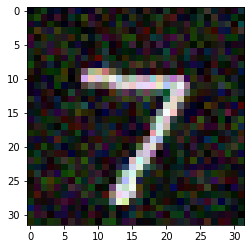

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


Adversarial image at step 121. L2 error 1757.7153620987717 and class label 6.


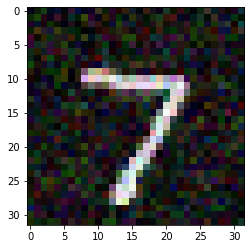

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


Adversarial image at step 122. L2 error 1755.6788677027835 and class label 6.


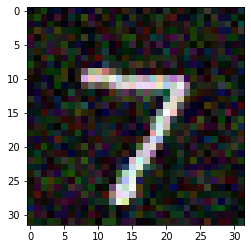

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


Adversarial image at step 123. L2 error 1752.5212472822643 and class label 6.


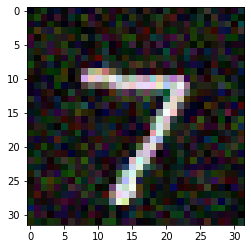

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


Adversarial image at step 124. L2 error 1749.1121083147125 and class label 6.


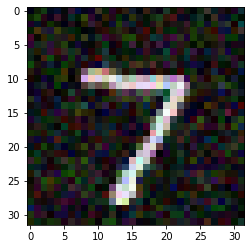

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


Adversarial image at step 125. L2 error 1746.926030018804 and class label 6.


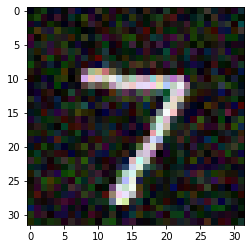

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


Adversarial image at step 126. L2 error 1745.1260074538611 and class label 6.


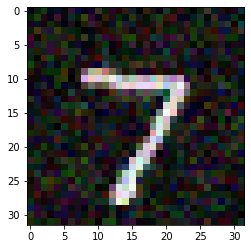

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


Adversarial image at step 127. L2 error 1743.7479302760012 and class label 6.


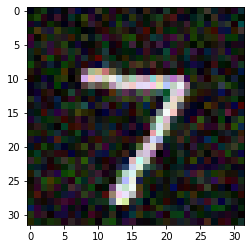

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


Adversarial image at step 128. L2 error 1741.1081793941255 and class label 6.


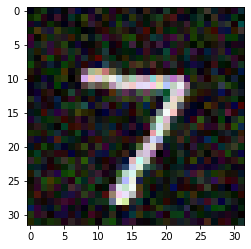

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


Adversarial image at step 129. L2 error 1739.5361472185466 and class label 6.


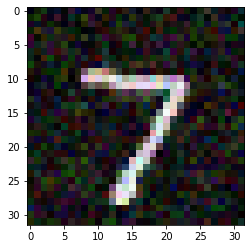

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Adversarial image at step 130. L2 error 1735.9737291487252 and class label 6.


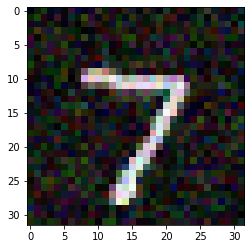

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


Adversarial image at step 131. L2 error 1733.5626981765781 and class label 6.


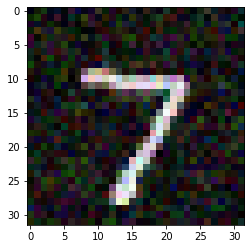

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


Adversarial image at step 132. L2 error 1730.793694397123 and class label 6.


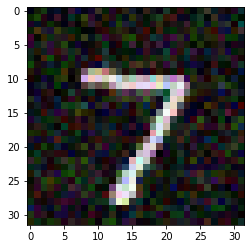

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


Adversarial image at step 133. L2 error 1727.398983081571 and class label 6.


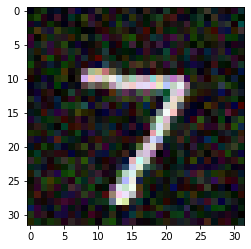

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


Adversarial image at step 134. L2 error 1723.2264175842072 and class label 6.


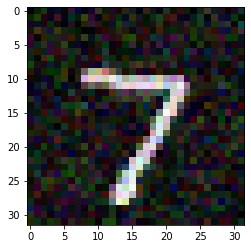

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]


Adversarial image at step 135. L2 error 1718.9613537645232 and class label 6.


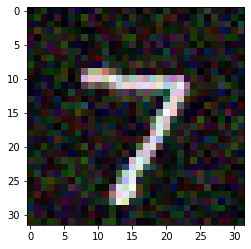

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


Adversarial image at step 136. L2 error 1713.8820378823377 and class label 6.


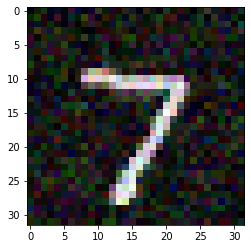

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


Adversarial image at step 137. L2 error 1710.4449041192204 and class label 6.


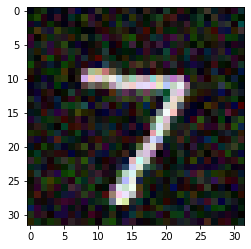

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Adversarial image at step 138. L2 error 1708.2835006529501 and class label 6.


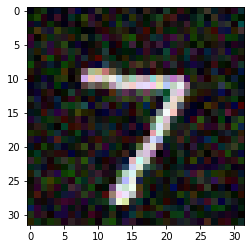

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


Adversarial image at step 139. L2 error 1705.8964566727443 and class label 6.


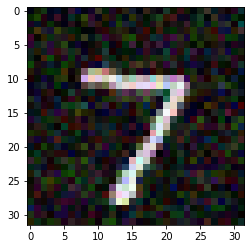

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


Adversarial image at step 140. L2 error 1704.502309324495 and class label 6.


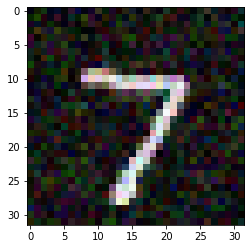

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


Adversarial image at step 141. L2 error 1701.0796512239099 and class label 6.


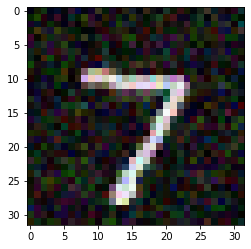

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.79it/s]


Adversarial image at step 142. L2 error 1697.4287200427464 and class label 6.


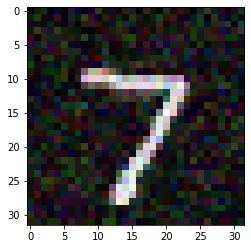

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


Adversarial image at step 143. L2 error 1692.5682184375207 and class label 6.


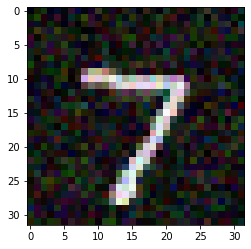

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


Adversarial image at step 144. L2 error 1686.1564877432213 and class label 6.


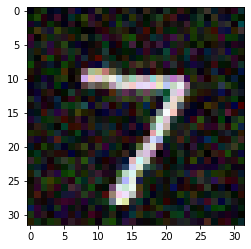

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


Adversarial image at step 145. L2 error 1681.9315945259973 and class label 6.


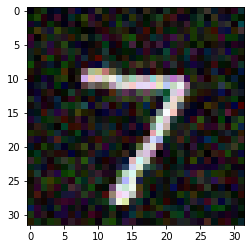

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


Adversarial image at step 146. L2 error 1677.265887342514 and class label 6.


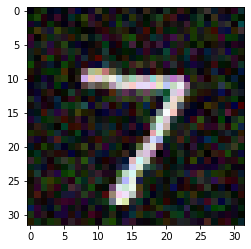

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Adversarial image at step 147. L2 error 1672.857736969548 and class label 6.


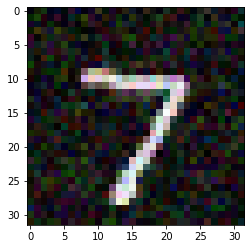

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


Adversarial image at step 148. L2 error 1669.3206441587272 and class label 6.


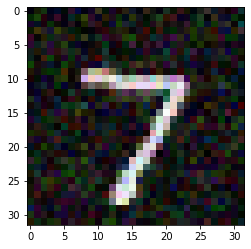

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


Adversarial image at step 149. L2 error 1665.4983107475646 and class label 6.


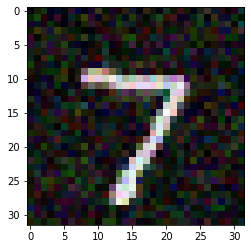

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.73it/s]


Adversarial image at step 150. L2 error 1664.113681080195 and class label 6.


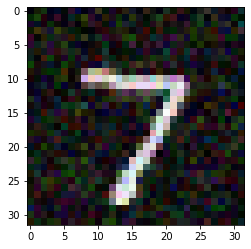

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Adversarial image at step 151. L2 error 1660.6123076625347 and class label 6.


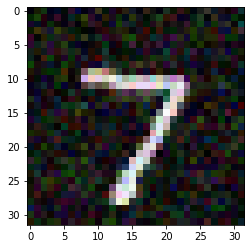

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


Adversarial image at step 152. L2 error 1657.6031399241422 and class label 6.


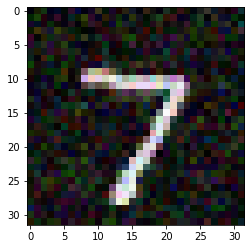

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


Adversarial image at step 153. L2 error 1656.6803836794647 and class label 6.


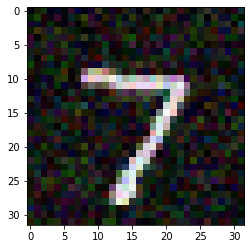

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.73it/s]


Adversarial image at step 154. L2 error 1655.5704705323526 and class label 6.


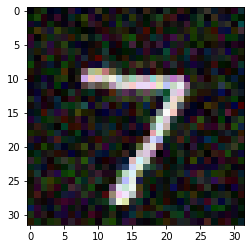

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


Adversarial image at step 155. L2 error 1654.1993488683925 and class label 6.


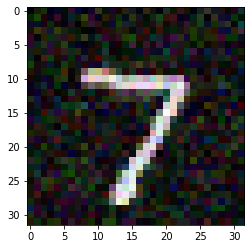

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


Adversarial image at step 156. L2 error 1652.515102718719 and class label 6.


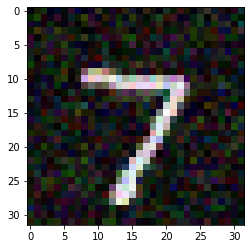

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


Adversarial image at step 157. L2 error 1650.4312372068123 and class label 6.


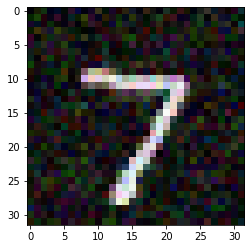

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


Adversarial image at step 158. L2 error 1647.847262626265 and class label 6.


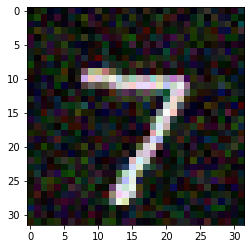

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

Adversarial image at step 159. L2 error 1645.7056487646494 and class label 6.


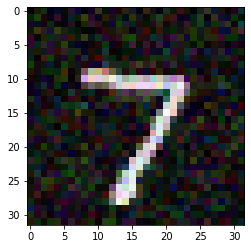

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


Adversarial image at step 160. L2 error 1644.6521724103598 and class label 6.


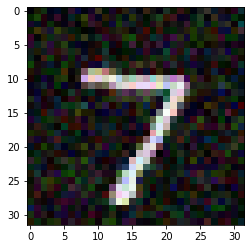

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


Adversarial image at step 161. L2 error 1643.1121464495427 and class label 6.


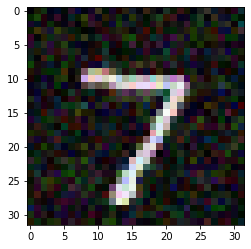

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


Adversarial image at step 162. L2 error 1641.3300540943765 and class label 6.


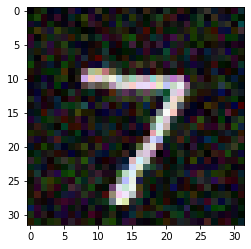

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.69it/s]


Adversarial image at step 163. L2 error 1641.3533417108113 and class label 6.


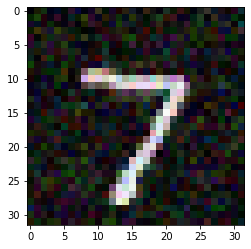

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


Adversarial image at step 164. L2 error 1640.8576907684394 and class label 6.


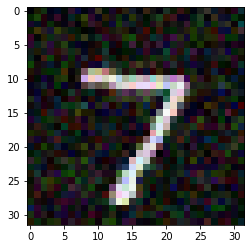

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


Adversarial image at step 165. L2 error 1640.3617390004392 and class label 6.


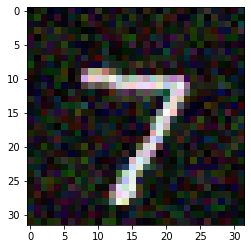

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


Adversarial image at step 166. L2 error 1639.4524223827327 and class label 6.


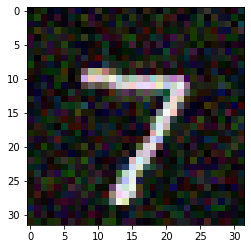

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


Adversarial image at step 167. L2 error 1638.30587784274 and class label 6.


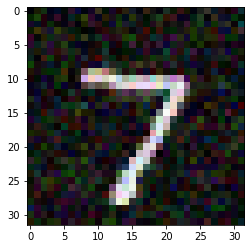

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


Adversarial image at step 168. L2 error 1637.1187466115844 and class label 6.


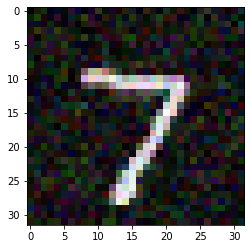

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


Adversarial image at step 169. L2 error 1636.0831740892875 and class label 6.


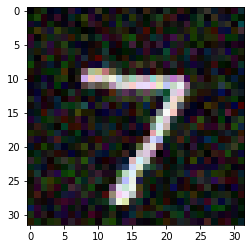

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


Adversarial image at step 170. L2 error 1634.97715829695 and class label 6.


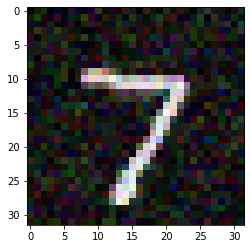

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.77it/s]


Adversarial image at step 171. L2 error 1634.26717305252 and class label 6.


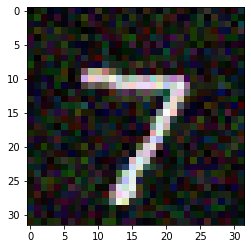

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]


Adversarial image at step 172. L2 error 1632.8360166594675 and class label 6.


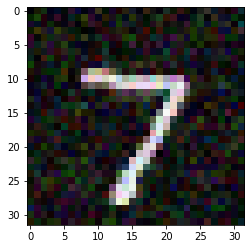

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


Adversarial image at step 173. L2 error 1631.4584612737094 and class label 6.


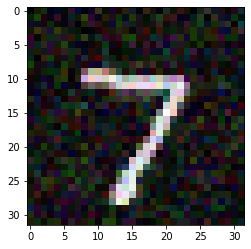

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


Adversarial image at step 174. L2 error 1628.919798628169 and class label 6.


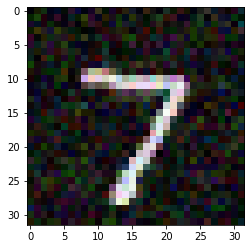

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


Adversarial image at step 175. L2 error 1626.491174536398 and class label 6.


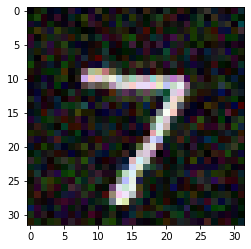

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]


Adversarial image at step 176. L2 error 1624.639502733866 and class label 6.


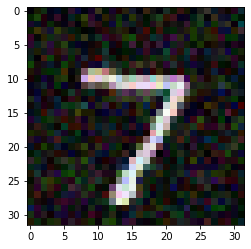

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.75it/s]


Adversarial image at step 177. L2 error 1623.4873635998035 and class label 6.


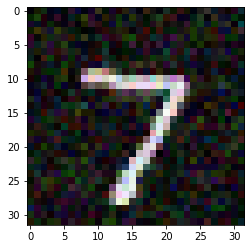

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


Adversarial image at step 178. L2 error 1621.9158484042575 and class label 6.


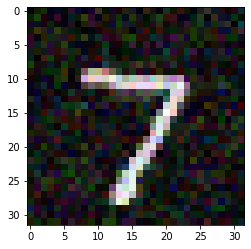

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


Adversarial image at step 179. L2 error 1619.8236774760264 and class label 6.


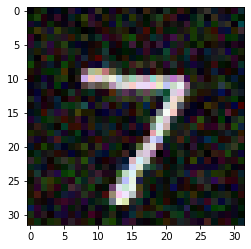

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


Adversarial image at step 180. L2 error 1617.239266533741 and class label 6.


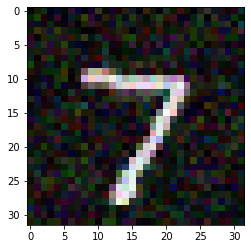

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


Adversarial image at step 181. L2 error 1614.1384717060675 and class label 6.


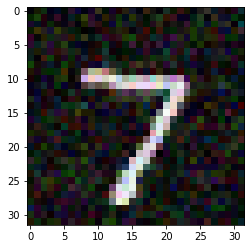

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


Adversarial image at step 182. L2 error 1611.6645408250438 and class label 6.


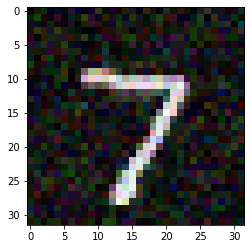

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.67it/s]


Adversarial image at step 183. L2 error 1610.1208716879105 and class label 6.


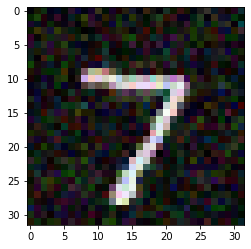

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


Adversarial image at step 184. L2 error 1608.692083445148 and class label 6.


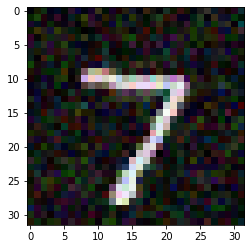

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


Adversarial image at step 185. L2 error 1606.8045121394914 and class label 6.


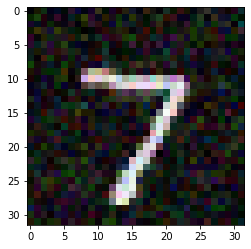

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


Adversarial image at step 186. L2 error 1603.5554445774876 and class label 6.


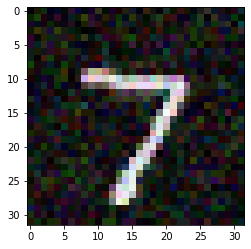

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


Adversarial image at step 187. L2 error 1600.0251486791203 and class label 6.


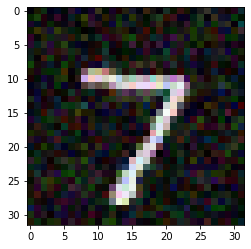

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]


Adversarial image at step 188. L2 error 1598.5679018171707 and class label 6.


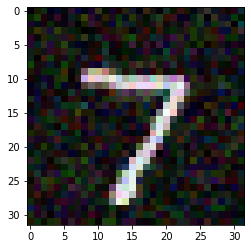

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


Adversarial image at step 189. L2 error 1597.7687595555044 and class label 6.


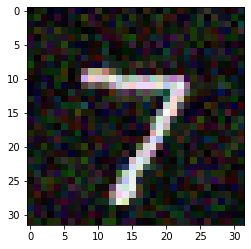

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.89it/s]


Adversarial image at step 190. L2 error 1596.7245501030504 and class label 6.


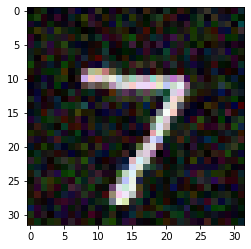

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


Adversarial image at step 191. L2 error 1595.5992719471049 and class label 6.


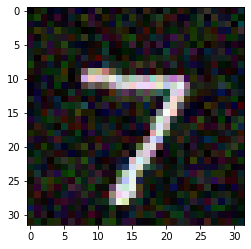

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


Adversarial image at step 192. L2 error 1594.7328003252778 and class label 6.


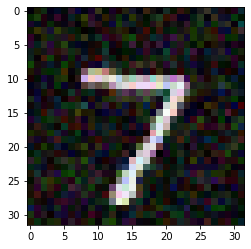

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]


Adversarial image at step 193. L2 error 1592.3595830885042 and class label 6.


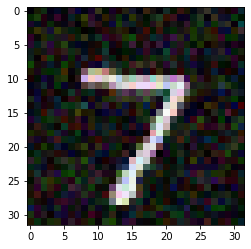

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


Adversarial image at step 194. L2 error 1590.9477008699175 and class label 6.


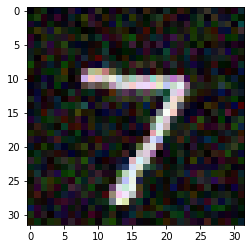

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


Adversarial image at step 195. L2 error 1588.3836373458078 and class label 6.


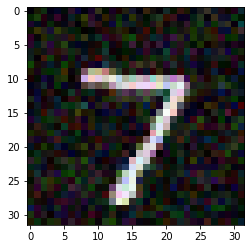

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


Adversarial image at step 196. L2 error 1585.6934878813356 and class label 6.


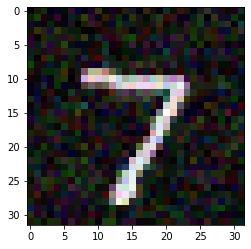

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


Adversarial image at step 197. L2 error 1584.5011315474467 and class label 6.


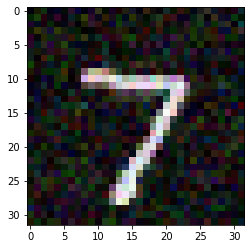

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


Adversarial image at step 198. L2 error 1582.4208585907415 and class label 6.


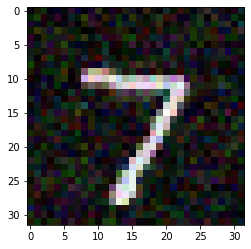

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Adversarial image at step 199. L2 error 1579.5236287314515 and class label 6.


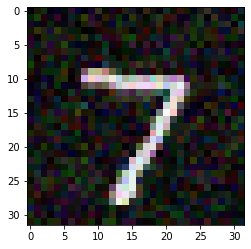

In [348]:
classifier = TensorFlowV2Classifier(model=small_model, input_shape=(32,32,3),clip_values=(0, 255),nb_classes=10)
degree_of_change={}
attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=0, delta=0.001, epsilon=0.001)
iter_step =1
x_adv = None
for i in range(200):
    x_adv = attack.generate(x=np.array([X_test[0]]), x_adv_init=x_adv)

    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - X_test[0], [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(x_adv[0][..., ::-1].astype(np.uint))
    plt.show(block=False)
    degree_of_change[i * iter_step]=DOC([x_adv[0]],[X_test[0]])
    
    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step 
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break




Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 132.86it/s]

Adversarial image at step 0. L2 error 7922.793122081539 and class label 8.


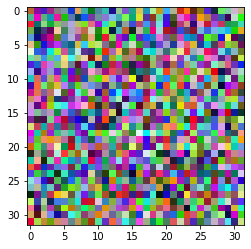

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Adversarial image at step 1. L2 error 7914.81046354 and class label 8.


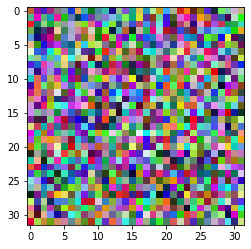

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


Adversarial image at step 2. L2 error 7902.9149672994245 and class label 2.


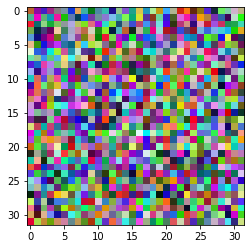

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


Adversarial image at step 3. L2 error 7902.597440175028 and class label 0.


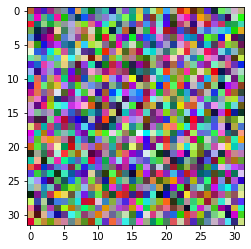

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


Adversarial image at step 4. L2 error 7901.930134164004 and class label 8.


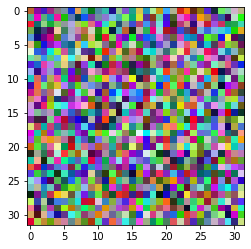

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


Adversarial image at step 5. L2 error 7901.119364409463 and class label 8.


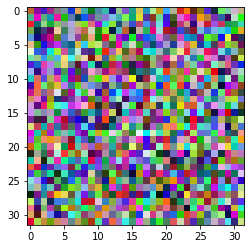

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

Adversarial image at step 6. L2 error 7900.802942808196 and class label 8.


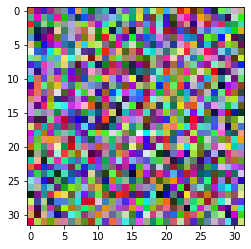

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


Adversarial image at step 7. L2 error 7900.429475819081 and class label 2.


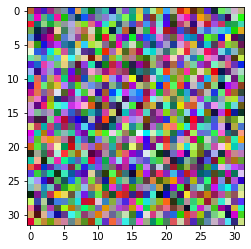

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


Adversarial image at step 8. L2 error 7900.048120411194 and class label 5.


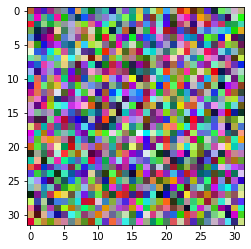

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]


Adversarial image at step 9. L2 error 7900.019530312881 and class label 3.


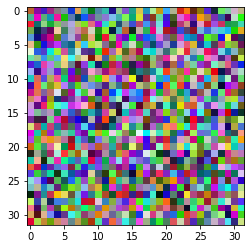

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]


Adversarial image at step 10. L2 error 7899.769116698202 and class label 4.


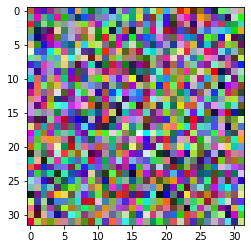

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]


Adversarial image at step 11. L2 error 7899.520860846833 and class label 2.


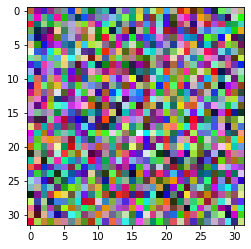

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


Adversarial image at step 12. L2 error 7899.019220427553 and class label 8.


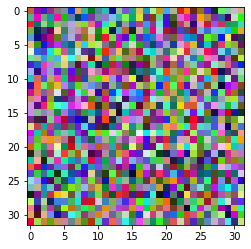

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


Adversarial image at step 13. L2 error 7897.96564205667 and class label 3.


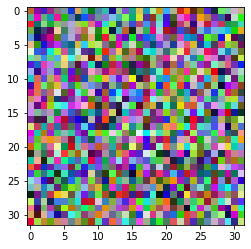

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


Adversarial image at step 14. L2 error 7897.585905373952 and class label 8.


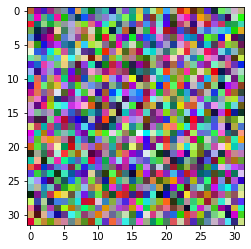

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

Adversarial image at step 15. L2 error 7897.558810684712 and class label 5.


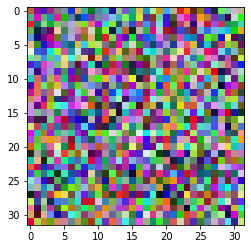

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

Adversarial image at step 16. L2 error 7897.541078837314 and class label 8.


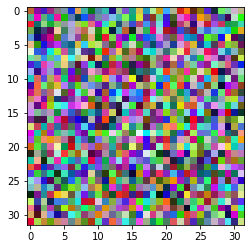

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


Adversarial image at step 17. L2 error 7897.535576988347 and class label 3.


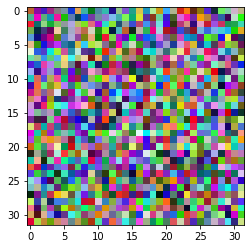

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


Adversarial image at step 18. L2 error 7897.52912366832 and class label 8.


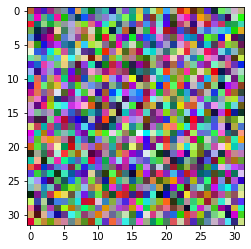

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

Adversarial image at step 19. L2 error 8010.422484023663 and class label 7.


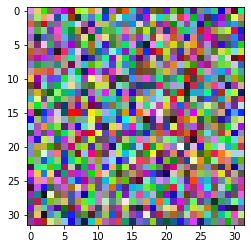

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

Adversarial image at step 20. L2 error 8010.41905471034 and class label 3.


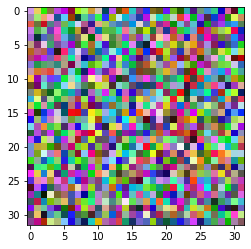

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

Adversarial image at step 21. L2 error 8010.4203353750145 and class label 8.


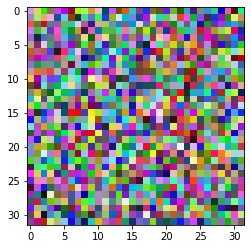

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]


Adversarial image at step 22. L2 error 8010.420561149251 and class label 2.


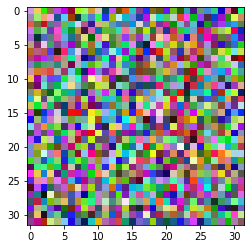

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


Adversarial image at step 23. L2 error 8010.419552163376 and class label 8.


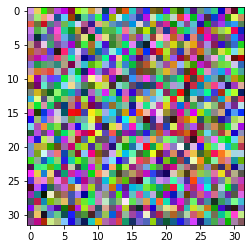

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


Adversarial image at step 24. L2 error 8010.422540706443 and class label 8.


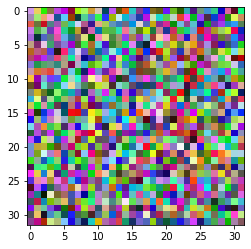

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


Adversarial image at step 25. L2 error 8010.420973449352 and class label 8.


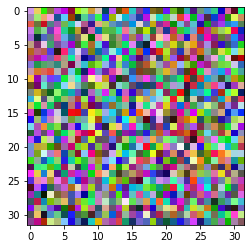

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

Adversarial image at step 26. L2 error 8010.420440561754 and class label 3.


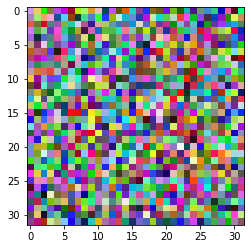

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]


Adversarial image at step 27. L2 error 8010.420579467924 and class label 8.


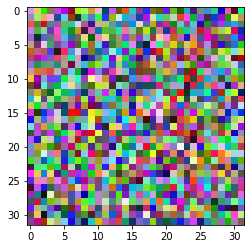

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]


Adversarial image at step 28. L2 error 8010.42041178852 and class label 5.


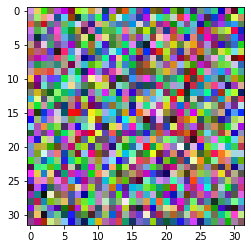

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]


Adversarial image at step 29. L2 error 8010.4210047384095 and class label 3.


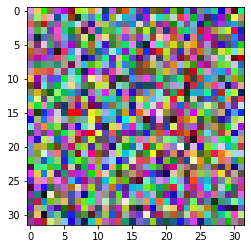

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]


Adversarial image at step 30. L2 error 8010.420728367531 and class label 8.


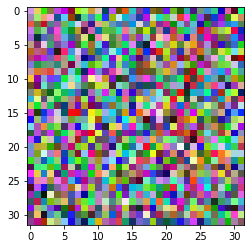

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]


Adversarial image at step 31. L2 error 8010.421144205325 and class label 8.


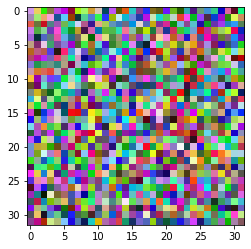

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]


Adversarial image at step 32. L2 error 8010.421453784397 and class label 8.


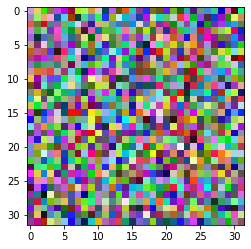

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

Adversarial image at step 33. L2 error 8010.421443228754 and class label 8.


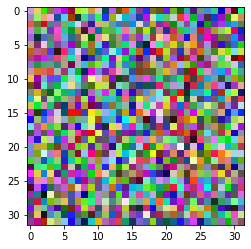

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]


Adversarial image at step 34. L2 error 8010.4213785472875 and class label 8.


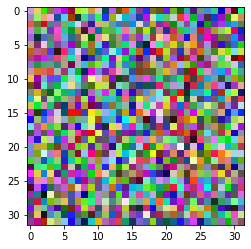

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


Adversarial image at step 35. L2 error 8010.421348920761 and class label 2.


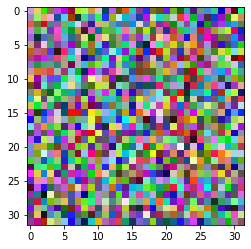

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]


Adversarial image at step 36. L2 error 8010.421279313261 and class label 8.


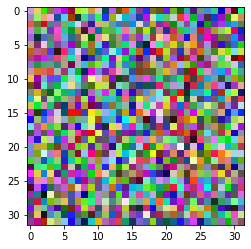

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


Adversarial image at step 37. L2 error 8010.421307128297 and class label 8.


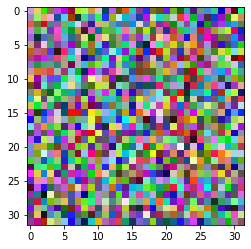

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


Adversarial image at step 38. L2 error 8010.421311386271 and class label 3.


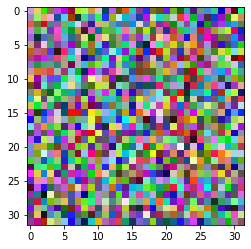

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


Adversarial image at step 39. L2 error 8010.42133213306 and class label 8.


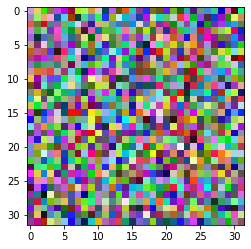

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


Adversarial image at step 40. L2 error 8010.4213146289685 and class label 3.


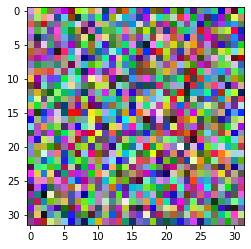

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]


Adversarial image at step 41. L2 error 8010.421397036903 and class label 8.


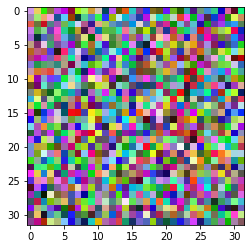

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]


Adversarial image at step 42. L2 error 8010.421473726988 and class label 8.


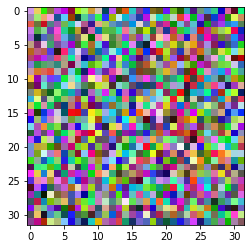

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]


Adversarial image at step 43. L2 error 8010.4215380460255 and class label 2.


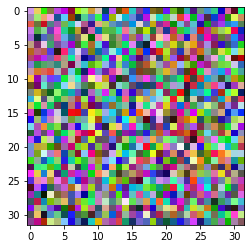

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


Adversarial image at step 44. L2 error 8010.421545028912 and class label 8.


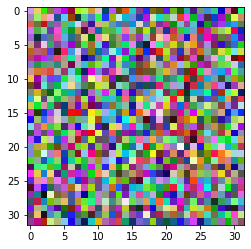

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


Adversarial image at step 45. L2 error 8010.421552645988 and class label 6.


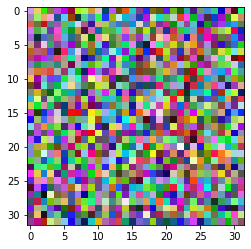

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

Adversarial image at step 46. L2 error 8010.421527941124 and class label 2.


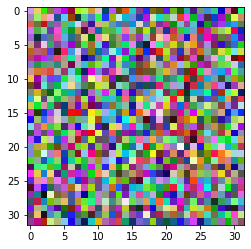

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


Adversarial image at step 47. L2 error 8010.421519677657 and class label 8.


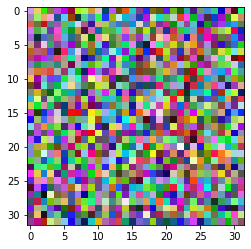

Boundary attack: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

Adversarial image at step 48. L2 error 8010.421520334197 and class label 8.


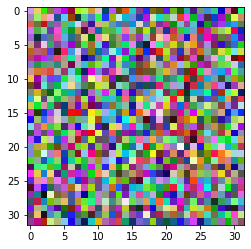

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]


Adversarial image at step 49. L2 error 8010.4215162987675 and class label 8.


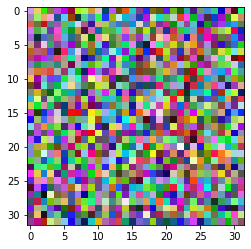

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


Adversarial image at step 50. L2 error 8010.421516613992 and class label 7.


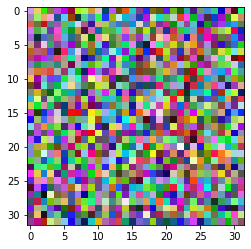

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


Adversarial image at step 51. L2 error 8010.421516941181 and class label 3.


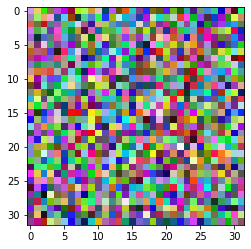

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


Adversarial image at step 52. L2 error 8010.421516792612 and class label 2.


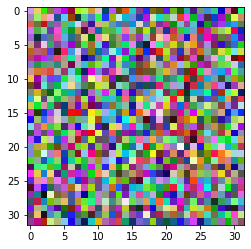

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


Adversarial image at step 53. L2 error 8010.421516332308 and class label 8.


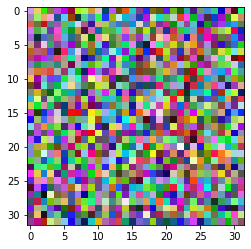

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]


Adversarial image at step 54. L2 error 8010.421514021129 and class label 2.


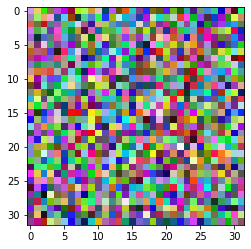

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


Adversarial image at step 55. L2 error 8010.421512681839 and class label 3.


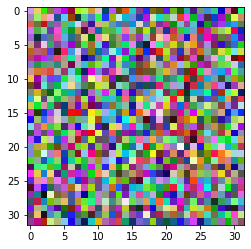

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


Adversarial image at step 56. L2 error 8010.421513142701 and class label 8.


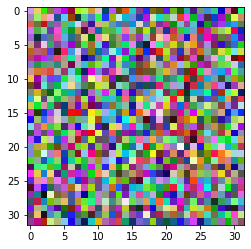

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


Adversarial image at step 57. L2 error 8010.421513721021 and class label 1.


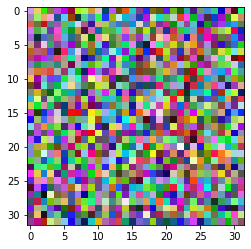

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


Adversarial image at step 58. L2 error 8010.421514063643 and class label 8.


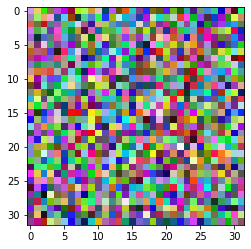

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]


Adversarial image at step 59. L2 error 8010.4215150976315 and class label 8.


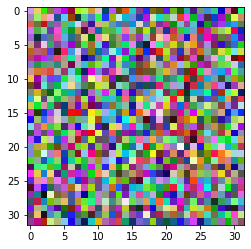

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


Adversarial image at step 60. L2 error 8010.421515149796 and class label 8.


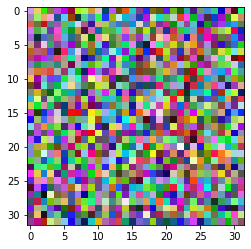

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

Adversarial image at step 61. L2 error 8010.4215154552685 and class label 8.


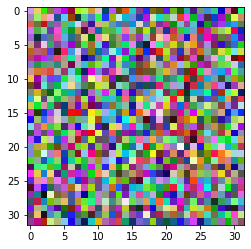

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

Adversarial image at step 62. L2 error 8010.421515508991 and class label 8.


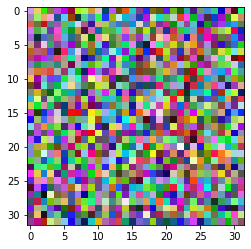

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]


Adversarial image at step 63. L2 error 8010.42151550698 and class label 4.


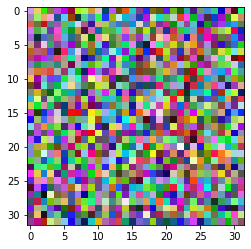

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


Adversarial image at step 64. L2 error 8010.421515590528 and class label 3.


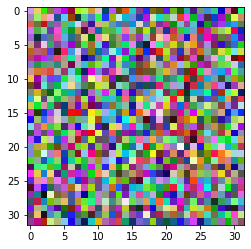

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

Adversarial image at step 65. L2 error 8010.421515562201 and class label 8.


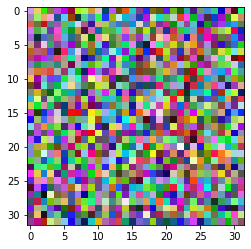

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


Adversarial image at step 66. L2 error 8010.421515540525 and class label 0.


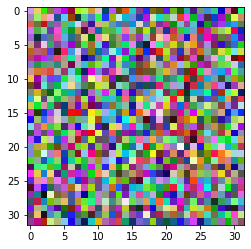

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


Adversarial image at step 67. L2 error 8010.421515553979 and class label 3.


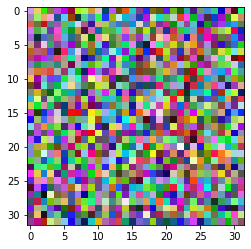

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


Adversarial image at step 68. L2 error 8010.421515556294 and class label 8.


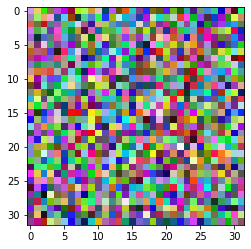

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


Adversarial image at step 69. L2 error 8010.4215155654 and class label 5.


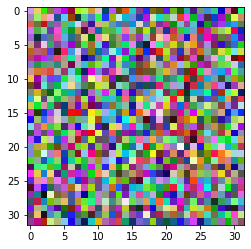

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


Adversarial image at step 70. L2 error 8010.421515565062 and class label 3.


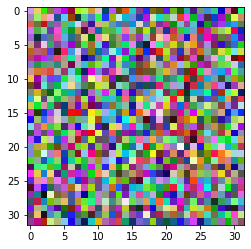

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]


Adversarial image at step 71. L2 error 8010.421515559923 and class label 0.


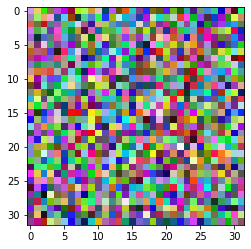

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

Adversarial image at step 72. L2 error 8010.421515551863 and class label 8.


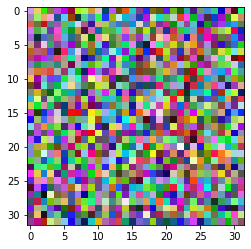

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]


Adversarial image at step 73. L2 error 8010.421515552972 and class label 8.


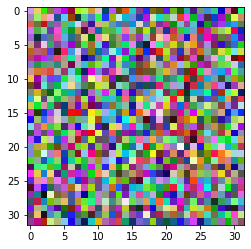

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


Adversarial image at step 74. L2 error 8010.421515555056 and class label 8.


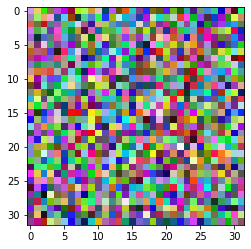

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]


Adversarial image at step 75. L2 error 8010.421515552261 and class label 2.


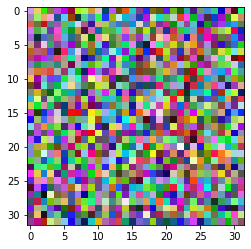

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

Adversarial image at step 76. L2 error 8010.421515552849 and class label 5.


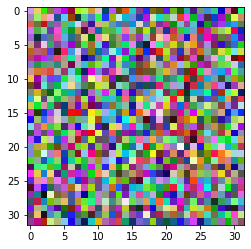

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]


Adversarial image at step 77. L2 error 8010.421515552211 and class label 8.


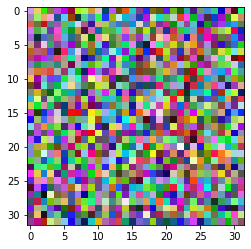

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


Adversarial image at step 78. L2 error 8010.421515552186 and class label 8.


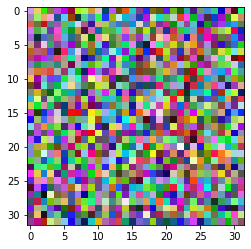

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


Adversarial image at step 79. L2 error 8010.421515552177 and class label 2.


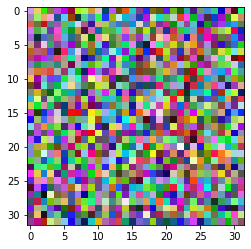

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

Adversarial image at step 80. L2 error 8010.421515552174 and class label 8.


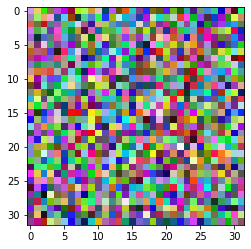

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


Adversarial image at step 81. L2 error 8010.421515552174 and class label 5.


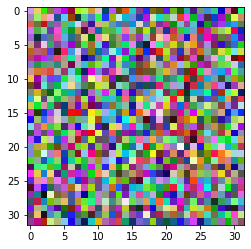

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]


Adversarial image at step 82. L2 error 8010.421515552174 and class label 8.


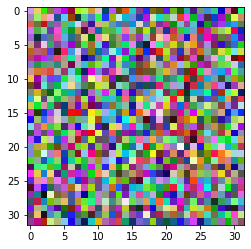

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


Adversarial image at step 83. L2 error 8010.421515552176 and class label 3.


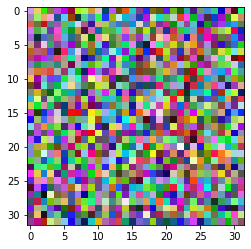

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


Adversarial image at step 84. L2 error 8010.421515552176 and class label 8.


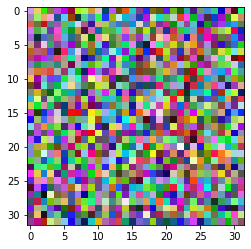

Boundary attack: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

Adversarial image at step 85. L2 error 8010.421515552176 and class label 5.


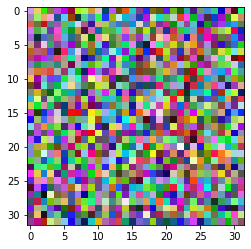

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


Adversarial image at step 86. L2 error 8010.421515552176 and class label 2.


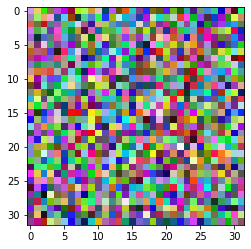

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

Adversarial image at step 87. L2 error 8010.421515552176 and class label 8.


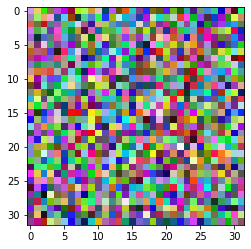

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


Adversarial image at step 88. L2 error 8010.421515552176 and class label 8.


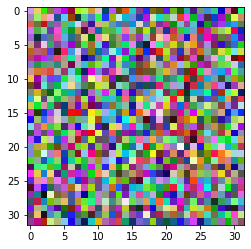

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


Adversarial image at step 89. L2 error 8010.421515552176 and class label 4.


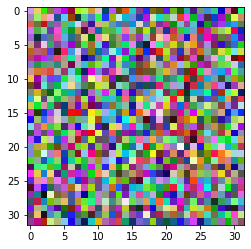

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]


Adversarial image at step 90. L2 error 8010.421515552176 and class label 3.


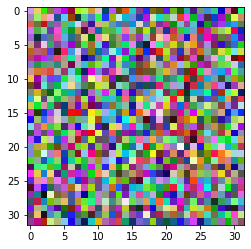

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

Adversarial image at step 91. L2 error 8010.421515552176 and class label 8.


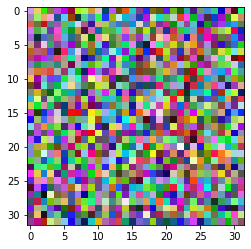

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]


Adversarial image at step 92. L2 error 8010.421515552176 and class label 8.


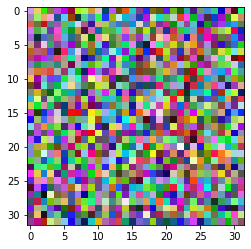

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]


Adversarial image at step 93. L2 error 8010.421515552176 and class label 2.


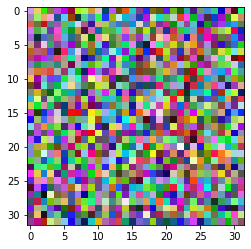

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


Adversarial image at step 94. L2 error 8010.421515552176 and class label 3.


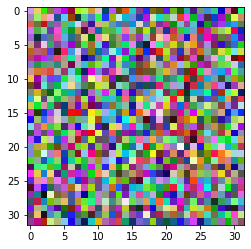

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

Adversarial image at step 95. L2 error 8010.421515552176 and class label 7.


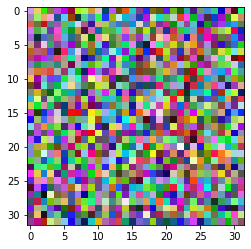

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


Adversarial image at step 96. L2 error 8010.421515552176 and class label 8.


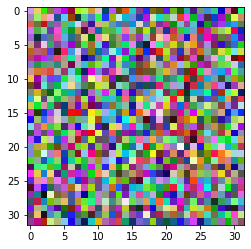

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


Adversarial image at step 97. L2 error 8010.421515552176 and class label 8.


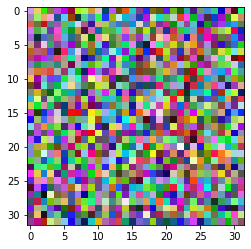

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


Adversarial image at step 98. L2 error 8010.421515552176 and class label 2.


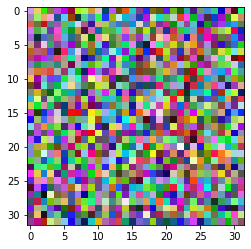

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

Adversarial image at step 99. L2 error 8010.421515552176 and class label 3.


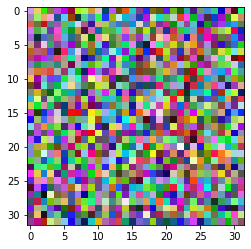

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


Adversarial image at step 100. L2 error 8045.236691064075 and class label 2.


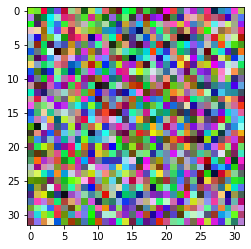

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]


Adversarial image at step 101. L2 error 8045.236691064075 and class label 8.


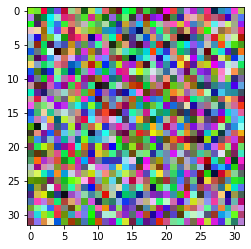

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


Adversarial image at step 102. L2 error 8045.236691064075 and class label 3.


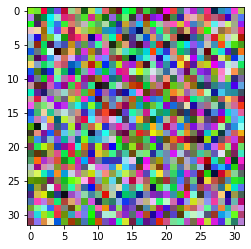

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]


Adversarial image at step 103. L2 error 8045.236691064075 and class label 8.


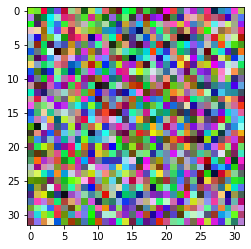

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]


Adversarial image at step 104. L2 error 8045.236691064075 and class label 8.


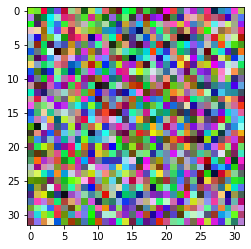

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]


Adversarial image at step 105. L2 error 8045.236691064075 and class label 2.


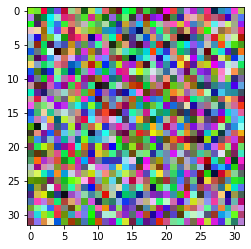

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


Adversarial image at step 106. L2 error 8045.236691064075 and class label 8.


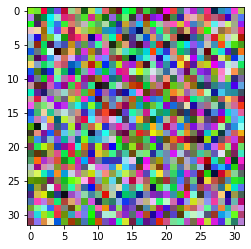

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


Adversarial image at step 107. L2 error 8045.236691064075 and class label 3.


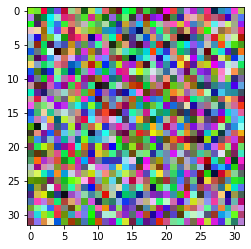

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

Adversarial image at step 108. L2 error 8045.236691064075 and class label 5.


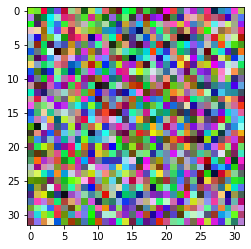

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]


Adversarial image at step 109. L2 error 8045.236691064075 and class label 4.


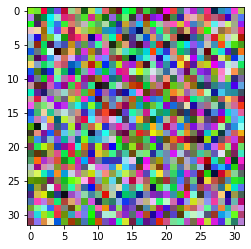

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]


Adversarial image at step 110. L2 error 8045.236691064075 and class label 8.


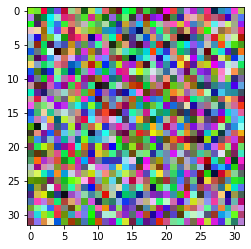

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


Adversarial image at step 111. L2 error 8045.236691064075 and class label 2.


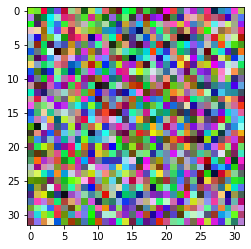

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.55it/s]


Adversarial image at step 112. L2 error 8045.236691064075 and class label 5.


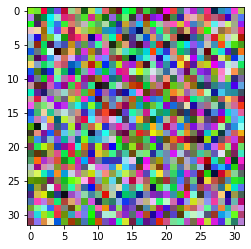

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]


Adversarial image at step 113. L2 error 8045.236691064075 and class label 8.


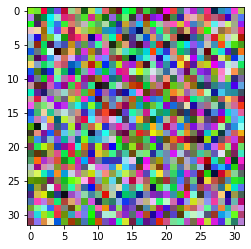

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


Adversarial image at step 114. L2 error 8045.236691064075 and class label 0.


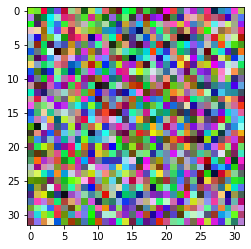

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]


Adversarial image at step 115. L2 error 8045.236691064075 and class label 8.


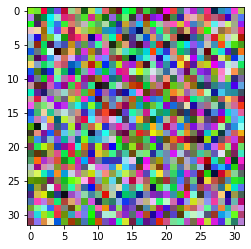

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

Adversarial image at step 116. L2 error 8045.236691064075 and class label 4.


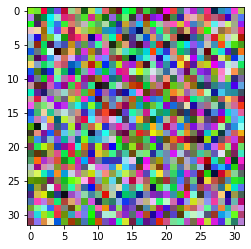

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

Adversarial image at step 117. L2 error 8045.236691064075 and class label 3.


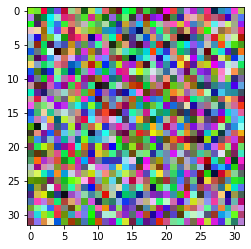

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


Adversarial image at step 118. L2 error 7960.239084732811 and class label 3.


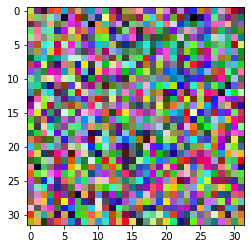

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


Adversarial image at step 119. L2 error 7960.239084732811 and class label 3.


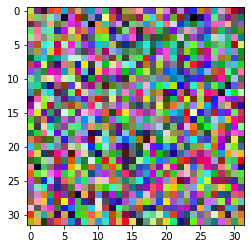

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


Adversarial image at step 120. L2 error 7960.239084732811 and class label 8.


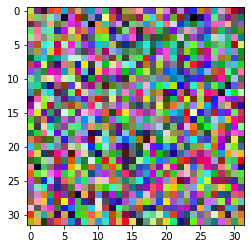

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]


Adversarial image at step 121. L2 error 7960.239084732811 and class label 2.


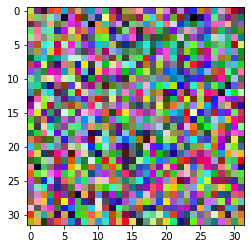

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]


Adversarial image at step 122. L2 error 7960.239084732811 and class label 8.


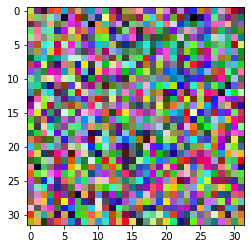

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


Adversarial image at step 123. L2 error 7960.239084732811 and class label 8.


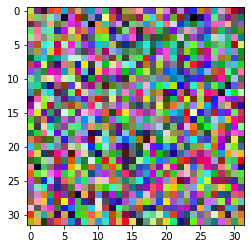

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]


Adversarial image at step 124. L2 error 7960.239084732811 and class label 8.


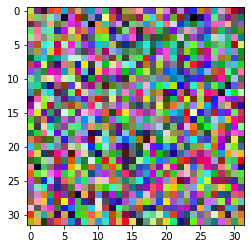

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


Adversarial image at step 125. L2 error 7960.239084732811 and class label 2.


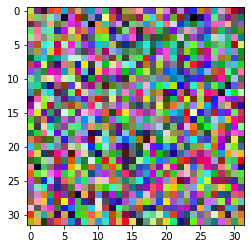

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]


Adversarial image at step 126. L2 error 7960.239084732811 and class label 5.


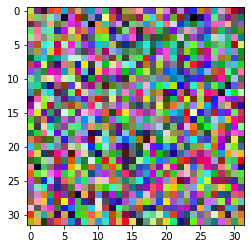

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


Adversarial image at step 127. L2 error 7960.239084732811 and class label 0.


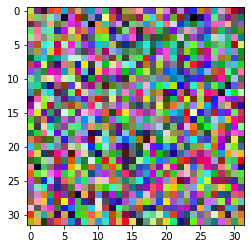

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


Adversarial image at step 128. L2 error 7960.239084732811 and class label 8.


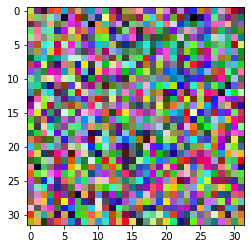

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


Adversarial image at step 129. L2 error 7960.239084732811 and class label 8.


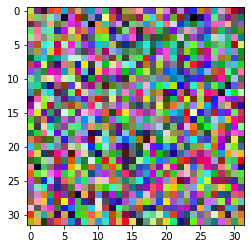

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


Adversarial image at step 130. L2 error 7960.239084732811 and class label 3.


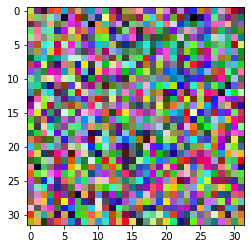

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

Adversarial image at step 131. L2 error 7960.239084732811 and class label 8.


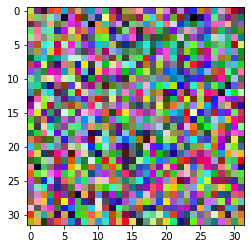

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]


Adversarial image at step 132. L2 error 7960.239084732811 and class label 8.


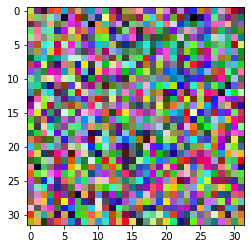

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


Adversarial image at step 133. L2 error 7960.239084732811 and class label 8.


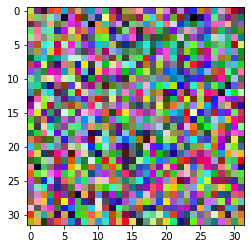

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


Adversarial image at step 134. L2 error 7960.239084732811 and class label 4.


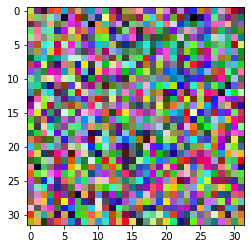

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


Adversarial image at step 135. L2 error 7960.239084732811 and class label 2.


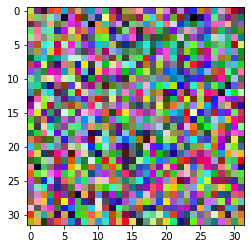

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


Adversarial image at step 136. L2 error 7960.239084732811 and class label 2.


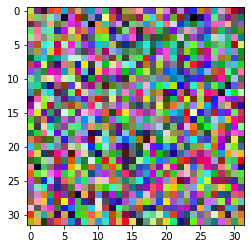

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.03it/s]


Adversarial image at step 137. L2 error 7960.239084732811 and class label 0.


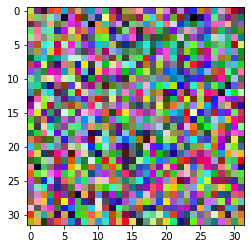

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


Adversarial image at step 138. L2 error 7960.239084732811 and class label 5.


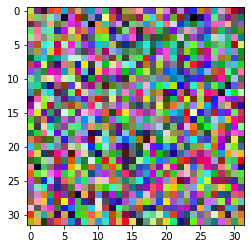

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


Adversarial image at step 139. L2 error 7960.239084732811 and class label 2.


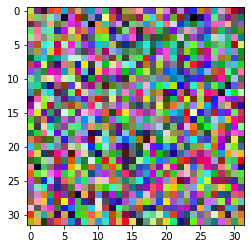

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


Adversarial image at step 140. L2 error 7960.239084732811 and class label 8.


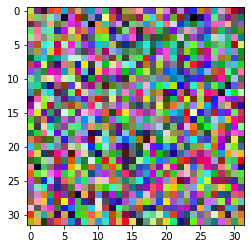

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]


Adversarial image at step 141. L2 error 7960.239084732811 and class label 2.


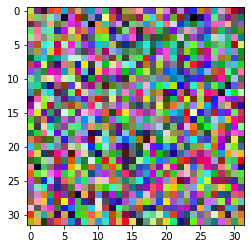

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]


Adversarial image at step 142. L2 error 7960.239084732811 and class label 5.


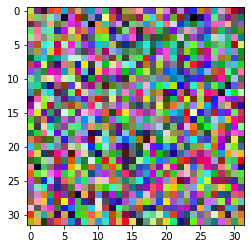

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


Adversarial image at step 143. L2 error 7960.239084732811 and class label 8.


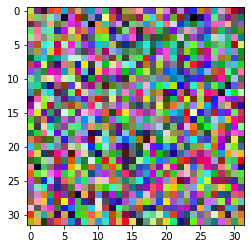

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


Adversarial image at step 144. L2 error 7960.239084732811 and class label 8.


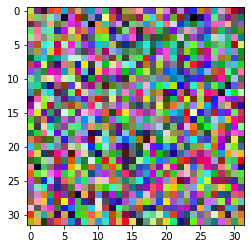

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]


Adversarial image at step 145. L2 error 7960.239084732811 and class label 3.


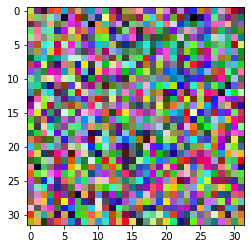

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


Adversarial image at step 146. L2 error 7960.239084732811 and class label 5.


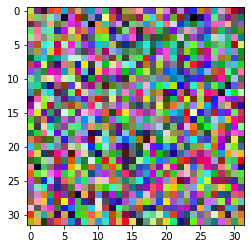

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]


Adversarial image at step 147. L2 error 7960.239084732811 and class label 2.


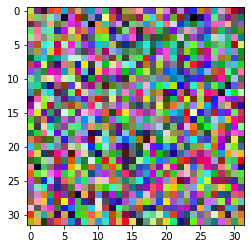

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

Adversarial image at step 148. L2 error 7960.239084732811 and class label 3.


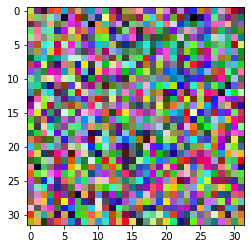

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


Adversarial image at step 149. L2 error 7960.239084732811 and class label 8.


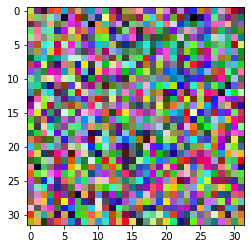

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]


Adversarial image at step 150. L2 error 7960.239084732811 and class label 4.


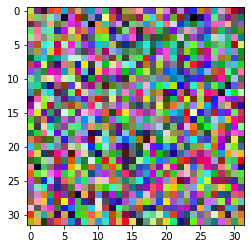

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


Adversarial image at step 151. L2 error 7960.239084732811 and class label 8.


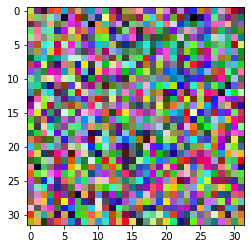

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]


Adversarial image at step 152. L2 error 7960.239084732811 and class label 8.


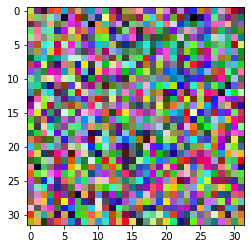

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]


Adversarial image at step 153. L2 error 7960.239084732811 and class label 8.


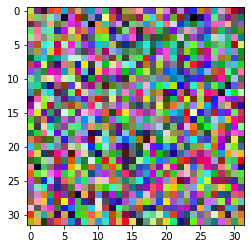

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

Adversarial image at step 154. L2 error 7960.239084732811 and class label 5.


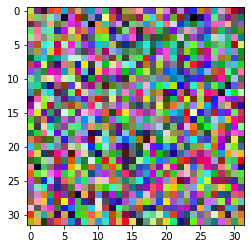

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


Adversarial image at step 155. L2 error 7960.239084732811 and class label 4.


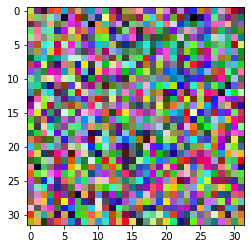

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


Adversarial image at step 156. L2 error 7960.239084732811 and class label 2.


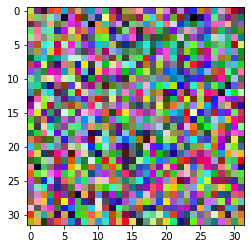

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]


Adversarial image at step 157. L2 error 7960.239084732811 and class label 5.


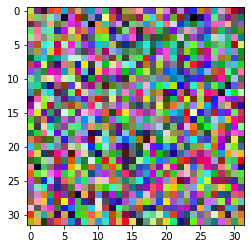

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


Adversarial image at step 158. L2 error 7960.239084732811 and class label 8.


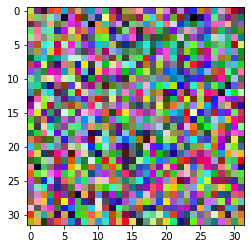

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

Adversarial image at step 159. L2 error 7960.239084732811 and class label 3.


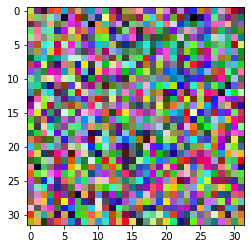

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


Adversarial image at step 160. L2 error 7960.239084732811 and class label 3.


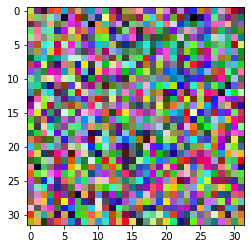

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


Adversarial image at step 161. L2 error 7960.239084732811 and class label 8.


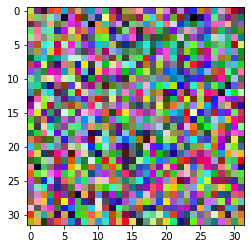

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


Adversarial image at step 162. L2 error 7960.239084732811 and class label 8.


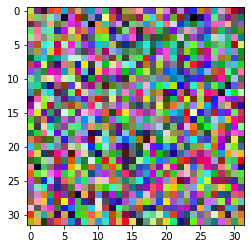

Boundary attack: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

Adversarial image at step 163. L2 error 7960.239084732811 and class label 7.


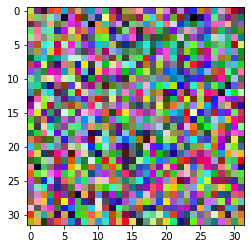

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


Adversarial image at step 164. L2 error 7960.239084732811 and class label 0.


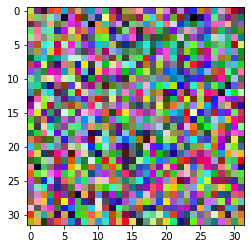

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


Adversarial image at step 165. L2 error 7960.239084732811 and class label 1.


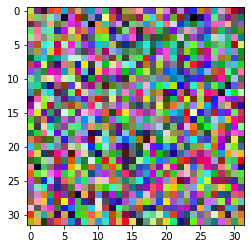

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

Adversarial image at step 166. L2 error 7960.239084732811 and class label 8.


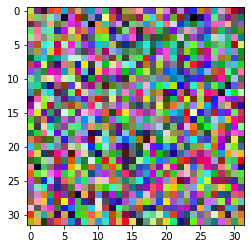

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]


Adversarial image at step 167. L2 error 7960.239084732811 and class label 5.


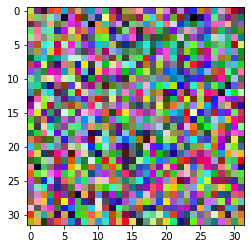

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


Adversarial image at step 168. L2 error 7960.239084732811 and class label 8.


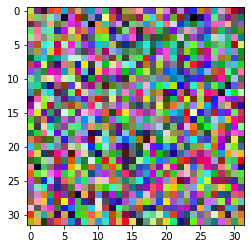

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]


Adversarial image at step 169. L2 error 7960.239084732811 and class label 5.


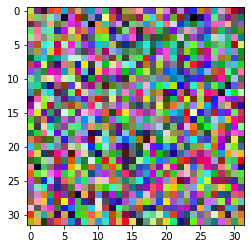

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]


Adversarial image at step 170. L2 error 7960.239084732811 and class label 2.


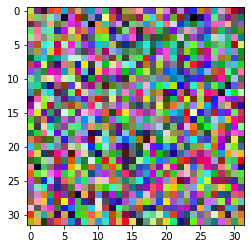

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


Adversarial image at step 171. L2 error 7960.239084732811 and class label 8.


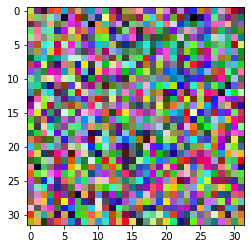

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

Adversarial image at step 172. L2 error 8007.311559168848 and class label 8.


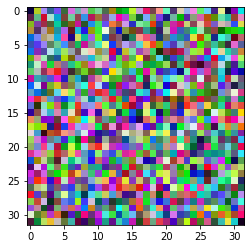

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


Adversarial image at step 173. L2 error 8007.311559168848 and class label 2.


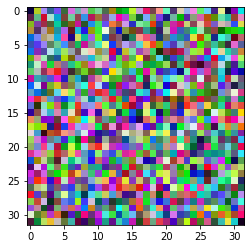

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

Adversarial image at step 174. L2 error 8007.311559168848 and class label 4.


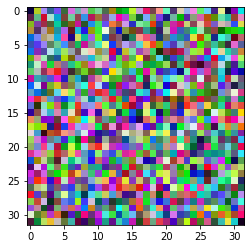

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]


Adversarial image at step 175. L2 error 8007.311559168848 and class label 8.


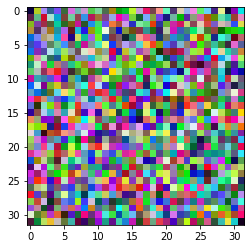

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

Adversarial image at step 176. L2 error 8007.311559168848 and class label 4.


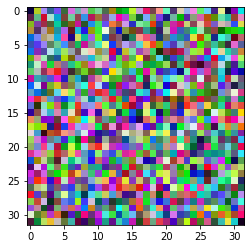

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


Adversarial image at step 177. L2 error 8007.311559168848 and class label 8.


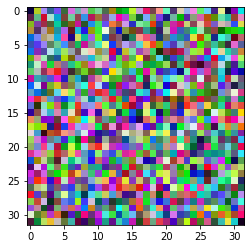

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


Adversarial image at step 178. L2 error 8007.311559168848 and class label 8.


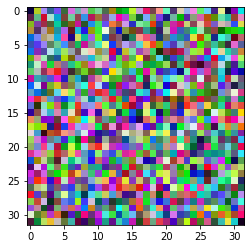

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


Adversarial image at step 179. L2 error 8007.311559168848 and class label 3.


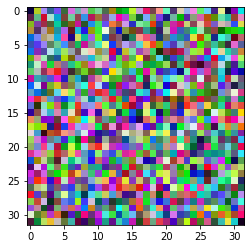

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


Adversarial image at step 180. L2 error 8007.311559168848 and class label 8.


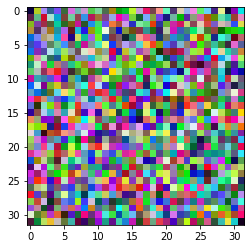

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


Adversarial image at step 181. L2 error 8007.311559168848 and class label 8.


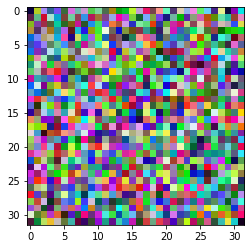

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


Adversarial image at step 182. L2 error 8007.311559168848 and class label 5.


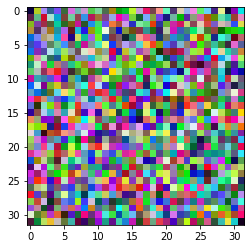

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


Adversarial image at step 183. L2 error 8007.311559168848 and class label 5.


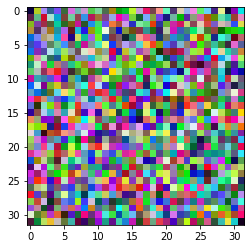

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]


Adversarial image at step 184. L2 error 8007.311559168848 and class label 8.


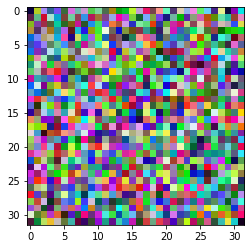

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


Adversarial image at step 185. L2 error 8007.311559168848 and class label 8.


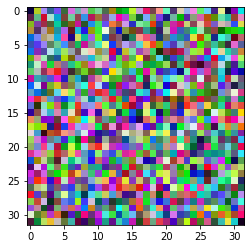

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


Adversarial image at step 186. L2 error 8007.311559168848 and class label 4.


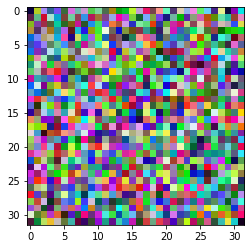

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

Adversarial image at step 187. L2 error 8007.311559168848 and class label 8.


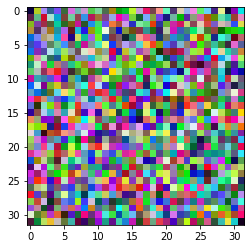

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


Adversarial image at step 188. L2 error 8007.311559168848 and class label 5.


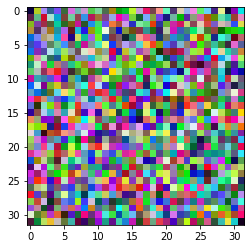

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


Adversarial image at step 189. L2 error 8007.311559168848 and class label 8.


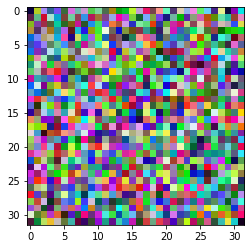

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


Adversarial image at step 190. L2 error 8007.311559168848 and class label 8.


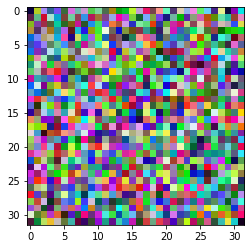

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

Adversarial image at step 191. L2 error 8007.311559168848 and class label 8.


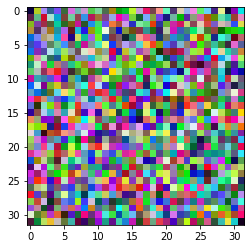

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

Adversarial image at step 192. L2 error 8007.311559168848 and class label 8.


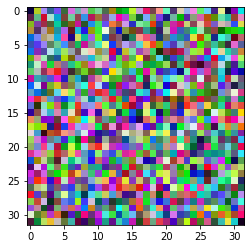

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


Adversarial image at step 193. L2 error 8007.311559168848 and class label 8.


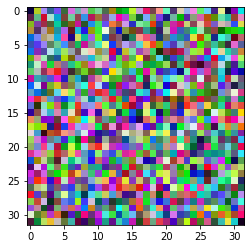

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

Adversarial image at step 194. L2 error 7908.49189437673 and class label 2.


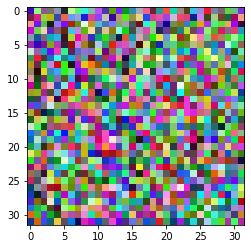

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


Adversarial image at step 195. L2 error 7908.49189437673 and class label 8.


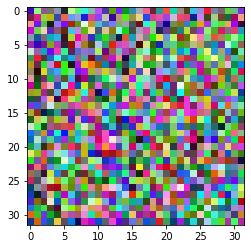

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


Adversarial image at step 196. L2 error 7908.49189437673 and class label 3.


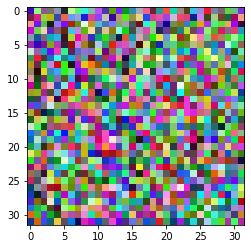

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


Adversarial image at step 197. L2 error 7908.49189437673 and class label 8.


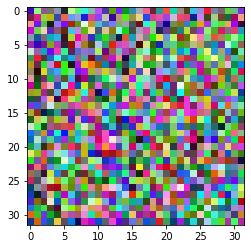

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


Adversarial image at step 198. L2 error 7908.49189437673 and class label 3.


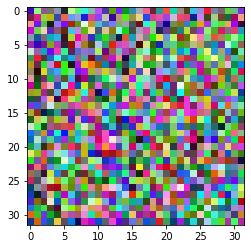

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


Adversarial image at step 199. L2 error 7908.49189437673 and class label 8.


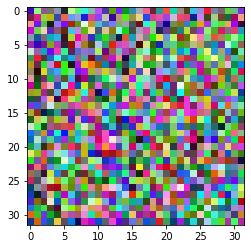

In [309]:
classifier = TensorFlowV2Classifier(model=small_model_with_def, input_shape=(32,32,3),clip_values=(0, 255),nb_classes=10)
degree_of_change_def={}
attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=0, delta=0.001, epsilon=0.001)
iter_step =1
x_adv = None
for i in range(200):
    x_adv = attack.generate(x=np.array([X_test[0]]), x_adv_init=x_adv)

    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - X_test[0], [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(x_adv[0][..., ::-1].astype(np.uint))
    plt.show(block=False)
    degree_of_change_def[i * iter_step]=DOC([x_adv[0]],[X_test[0]])
    
    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step 
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break


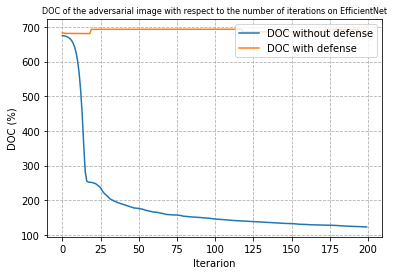

In [312]:
plt.plot(list(degree_of_change.keys()),list(degree_of_change.values()),label='DOC without defense')
plt.plot(list(degree_of_change_def.keys()),list(degree_of_change_def.values()),label='DOC with defense')
plt.grid(True,which="both", linestyle='--')
plt.title('DOC of the adversarial image with respect to the number of iterations on EfficientNet', fontsize=8)
plt.xlabel('Iterarion')
plt.ylabel('DOC (%)')
plt.legend(loc='upper right')
plt.show()